In [7]:
!pip install factor_analyzer

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for factor_analyzer: filename=factor_analyzer-0.5.1-py2.py3-none-any.whl size=42623 sha256=65cf7ebfc0027713057c07a3c5926e21f4f42d034d3f5537d85279d444c2e728
  Stored in directory: c:\users\amim gtac\appdata\local\pip\cache\wheels\a2\af\06\f4d4ed4d9d714fda437fb1583629417319603c2266e7b233cc
Successfully built factor_analyzer


In [36]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import openpyxl
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf

from scipy import stats
from scipy.stats import kurtosis, skew
from scipy.stats import f_oneway

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.metrics import mean_squared_error, r2_score

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


## Tratar DB

In [11]:
# # Rutas Alejandro - Local
# MAPA_ruta = r"C:\Users\Alejandro\Downloads\DATA\Factorial\Test Mérida\Mérida_Subtipologias (2).gpkg"

# Rutas Alejandro - SSD
MAPA_ruta = r"Z:\VOCES\DATA\Tratados\NAC\INT_MZN_NAC\Mzn_Tipologías_NAC_ImpEq.gpkg"


In [13]:
# subir pgkg
# Seleccionar nivel de deshabitación: a,b,c,d
#Limpiar columnas no-numéricas



MAPA_df = gpd.read_file(MAPA_ruta, layer='Mzn_Subtipologias_UeEq_filtrado')

In [32]:
MAPA_df.describe

<bound method NDFrame.describe of                   CVEGEO  POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
0       0100100010229006          25          26           8          10   
1       0100100010229007          99          56          18          14   
2       0100100010229008          78          46          20          22   
3       0100100010229010         134         114          51          51   
4       0100100010233006           1           1           1           2   
...                  ...         ...         ...         ...         ...   
938279         320170261          10          27          15          27   
938280         320560045         638         840         178         271   
938281         320560098         247         286         391         635   
938282         320170036         667         597         167         215   
938283         320170261          10          27          15          27   

        TVIVHAB2010  TVIVHAB2020  TVIVPAR2010  TVIVPA

In [ ]:
#limpiar columnas
MAPA_df_continuo = MAPA_df.drop(columns=[ 'CVE_ENT_x', 'CVE_MUN_x', 'CVE_LOC_x', 'CVE_AGEB_x',
       'CVE_MZA_x', 'AMBITO_x', 'TIPOMZA_x', 'NOMGEO_x', 'CVEMUN', 'CVE_MET', 'NOM_MET',
       'TIPO_MET', 'TIPO_MUN', 'CVE', 'geometry'])

#seleccionar micro-db de cada nivel de deshabitación
MAPA_df_a = MAPA_df_continuo[MAPA_df_continuo.R_DESHAB == 'a']
MAPA_df_b = MAPA_df_continuo[MAPA_df_continuo.R_DESHAB == 'b']
MAPA_df_c = MAPA_df_continuo[MAPA_df_continuo.R_DESHAB == 'c']
MAPA_df_d = MAPA_df_continuo[MAPA_df_continuo.R_DESHAB == 'd']

In [3]:
MAPA_df_a.columns

Index(['CVEGEO', 'POPTOT2010', 'POPTOT2020', 'VIVTOT2010', 'VIVTOT2020',
       'VIVPARDES2010', 'VIVPARDES2020', 'VIV1DO2010', 'VIV1DO2020',
       'VIV2YMDO2010', 'VIV2YMDO2020', 'VIV1C2010', 'VIV1C2020', 'VIV2C2010',
       'VIV2C2020', 'VIV3CYM2010', 'VIV3CYM2020', 'area_ha', 'FILTRADO',
       'DESHABITACION', 'PROM_DESHAB_MUN', 'TASA_POP_MUN', 'DIFPOP', 'DIFVIV',
       'RELPOP', 'RELVIV', 'CVEPOP', 'CVEVIV', 'TIPOLOGIA', 'DENS_POP20',
       'DENS_POP10', 'DENS_VIV20', 'DENS_VIV10', 'CUARTOS2010', 'CUARTOS2020',
       'CPERC2010', 'CPERC2020', 'HABXVIV2010', 'HABXVIV2020', 'R_DESHAB',
       'SUBTIPOLOGÍA'],
      dtype='object')

## Análisis Covarianza

In [34]:
# Supongamos que X es el conjunto de variables numéricas del GeoDataFrame
X = MAPA_df[['IMP_EDU', 'Emp_20']].copy()  # Reemplazar con tus columnas de interés

# Filtra las filas con valores nulos antes de aplicar EllipticEnvelope
X = X.dropna()  # Esto elimina las filas con valores nulos en X

# Filtra el GeoDataFrame según el índice de las filas válidas en X
MAPA_df_filtered = MAPA_df.loc[X.index]

# Detección de valores atípicos
outlier_detector = EllipticEnvelope(contamination=0.05)  # Ajuste de sensibilidad
outliers = outlier_detector.fit_predict(X)

# Filtrar el GeoDataFrame para eliminar los outliers
MAPA_df_clean = MAPA_df_filtered[outliers == 1]

In [38]:
# Asumiendo que ya tienes tu GeoDataFrame 'MAPA_df' limpio de valores atípicos
# Elegimos las columnas de interés
columnas_interes = ['IMP_EDU', 'Emp_20', 'TIPOLOGIA']  # Cambiar por las columnas que quieras usar
df = MAPA_df[columnas_interes].dropna()

# Ajustamos el modelo de ANCOVA
# 'INDICADOR1' es la variable dependiente, 'TIPOLOGIA' es la variable categórica, y 'INDICADOR2' es la covariable
modelo_ancova = smf.ols('IMP_EDU ~ C(TIPOLOGIA) + Emp_20', data=df).fit()

# Mostramos el resumen del modelo
print(modelo_ancova.summary())


                            OLS Regression Results                            
Dep. Variable:                IMP_EDU   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     4075.
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:57:24   Log-Likelihood:            -4.1221e+06
No. Observations:              563762   AIC:                         8.244e+06
Df Residuals:                  563753   BIC:                         8.244e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept             513.2070    

## Análisis correlacional simple

POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010         1.000000    0.818509    0.945875    0.747884   
POPTOT2020         0.818509    1.000000    0.789371    0.940603   
VIVTOT2010         0.945875    0.789371    1.000000    0.771276   
VIVTOT2020         0.747884    0.940603    0.771276    1.000000   
VIVPARDES2010      0.561762    0.415094    0.555088    0.342155   
VIVPARDES2020      0.585327    0.733959    0.612615    0.795524   
VIV1DO2010         0.744968    0.668286    0.731426    0.608371   
VIV1DO2020         0.545479    0.726291    0.541449    0.733344   
VIV2YMDO2010       0.912491    0.710605    0.916865    0.693701   
VIV2YMDO2020       0.737917    0.891603    0.763232    0.899629   
VIV1C2010          0.452763    0.480996    0.394837    0.405879   
VIV1C2020          0.340652    0.436978    0.284784    0.398345   
VIV2C2010          0.571670    0.551129    0.496879    0.455833   
VIV2C2020          0.412937    0.567869    0.370914    0.509631   
VIV3CYM2010        0.864795    0.653441    0.898670    0.657186   
VIV3CYM2020        0.696002    0.845070    0.742280    0.884181   
area_ha            0.469102    0.613667    0.426402    0.586618   
FILTRADO          -0.059413   -0.050329   -0.057229   -0.010435   
DESHABITACION      0.166597    0.178291    0.191937    0.234146   
PROM_DESHAB_MUN   -0.073625   -0.031928   -0.086858   -0.047283   
TASA_POP_MUN      -0.066782    0.026703   -0.078107    0.023604   
DIFPOP            -0.345602    0.256216   -0.302128    0.278028   
DIFVIV            -0.317637    0.197966   -0.364202    0.311885   
RELPOP            -0.162582   -0.031148   -0.107047   -0.025002   
RELVIV            -0.171155   -0.051150   -0.188149   -0.040277   
DENS_POP20         0.146533    0.185730    0.161604    0.168671   
DENS_POP10         0.449883    0.161213    0.440331    0.118666   
DENS_VIV20         0.031559    0.071819    0.072266    0.164161   
DENS_VIV10         0.385709    0.132027    0.468921    0.129036   
CUARTOS2010        0.915900    0.714361    0.939626    0.705949   
CUARTOS2020        0.729006    0.888482    0.766256    0.921189   
CPERC2010         -0.146946   -0.121073   -0.026836   -0.034612   
CPERC2020         -0.106459   -0.165994   -0.024410   -0.009326   
HABXVIV2010        0.274342    0.138325   -0.001567    0.010769   
HABXVIV2020        0.214708    0.235667    0.102975   -0.037818   

                 VIVPARDES2010  VIVPARDES2020  VIV1DO2010  VIV1DO2020  \
POPTOT2010            0.561762       0.585327    0.744968    0.545479   
POPTOT2020            0.415094       0.733959    0.668286    0.726291   
VIVTOT2010            0.555088       0.612615    0.731426    0.541449   
VIVTOT2020            0.342155       0.795524    0.608371    0.733344   
VIVPARDES2010         1.000000       0.347579    0.576393    0.362960   
VIVPARDES2020         0.347579       1.000000    0.514463    0.595425   
VIV1DO2010            0.576393       0.514463    1.000000    0.678555   
VIV1DO2020            0.362960       0.595425    0.678555    1.000000   
VIV2YMDO2010          0.445127       0.530883    0.480287    0.362651   
VIV2YMDO2020          0.299099       0.690757    0.452617    0.441867   
VIV1C2010             0.616209       0.395214    0.690324    0.540728   
VIV1C2020             0.419741       0.349762    0.506935    0.656468   
VIV2C2010             0.534069       0.387676    0.767141    0.597504   
VIV2C2020             0.337369       0.406385    0.602714    0.758364   
VIV3CYM2010           0.358196       0.495229    0.488039    0.324443   
VIV3CYM2020           0.236746       0.680781    0.410468    0.471338   
area_ha               0.437740       0.545366    0.490341    0.533466   
FILTRADO             -0.052829      -0.005221   -0.063942    0.018450   
DESHABITACION         0.044439       0.615251    0.167357    0.165057   
PROM_DESHAB_MUN      -0.069259      -0.029668   -0.027917   -0.000508   
TASA_POP_MUN         -0.121847       0.017932   -0.038635    0.041387  

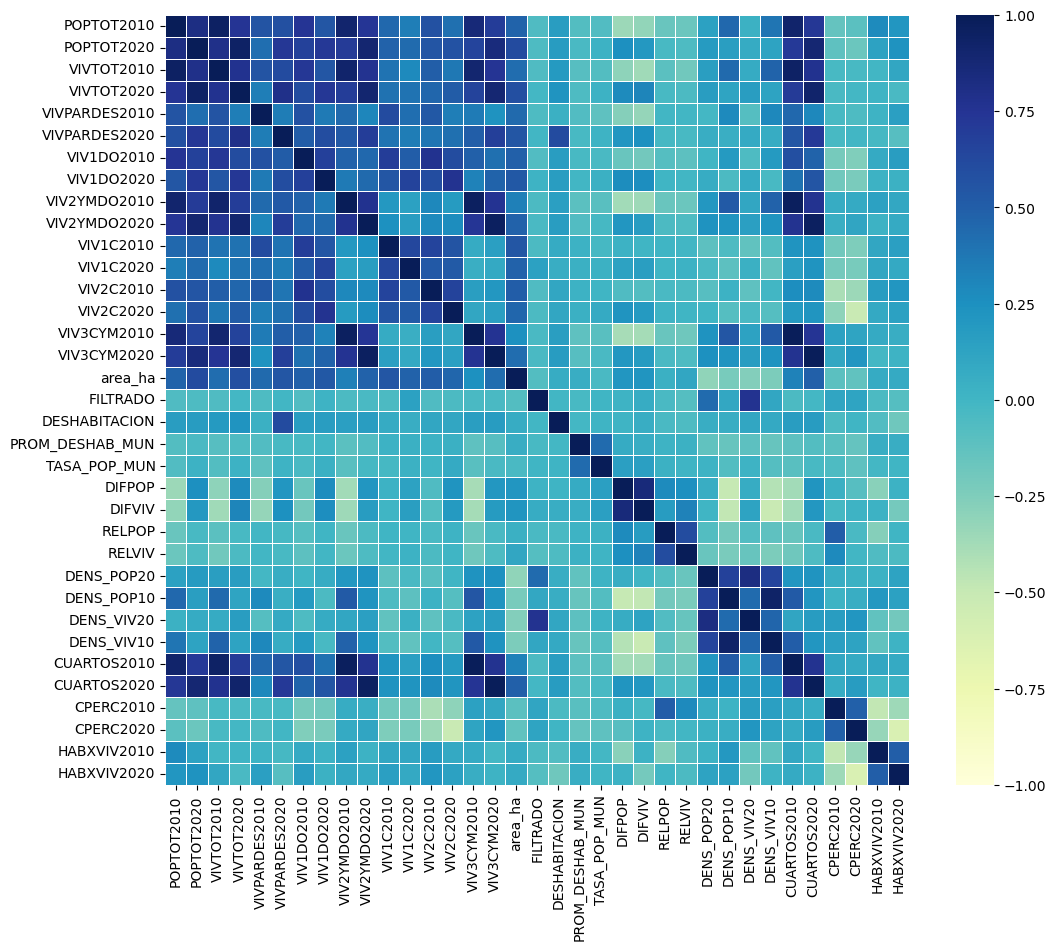

In [7]:
#df a analizar
MAPA_CM_f = MAPA_df_a

# Filtrar solo las columnas numéricas
MAPA_CM_f_numeric = MAPA_CM_f.select_dtypes(include=[np.number])

# Completa
correlaciones = MAPA_CM_f_numeric.corr()
display(correlaciones)

# Crear el heatmap de correlación
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlaciones, vmin=-1, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5)
plt.show()


POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010         1.000000    0.772231    0.944091    0.696064   
POPTOT2020         0.772231    1.000000    0.774676    0.970396   
VIVTOT2010         0.944091    0.774676    1.000000    0.735579   
VIVTOT2020         0.696064    0.970396    0.735579    1.000000   
VIVPARDES2010      0.446399    0.257123    0.430524    0.193704   
VIVPARDES2020      0.645636    0.921059    0.697890    0.964419   
VIV1DO2010         0.819878    0.677399    0.813369    0.617998   
VIV1DO2020         0.578335    0.789922    0.581018    0.794617   
VIV2YMDO2010       0.933629    0.706244    0.917937    0.663738   
VIV2YMDO2020       0.685650    0.927249    0.728307    0.941930   
VIV1C2010          0.464472    0.398302    0.378148    0.325085   
VIV1C2020          0.409442    0.428948    0.350793    0.389442   
VIV2C2010          0.603525    0.508692    0.524906    0.421483   
VIV2C2020          0.445046    0.568681    0.421795    0.526684   
VIV3CYM2010        0.912847    0.696358    0.932117    0.668886   
VIV3CYM2020        0.649169    0.908716    0.701834    0.941260   
area_ha            0.536133    0.636826    0.491933    0.602826   
FILTRADO          -0.143214   -0.124353   -0.132199   -0.103346   
DESHABITACION      0.039042    0.060643    0.064689    0.094870   
PROM_DESHAB_MUN   -0.015141    0.027065   -0.026488   -0.000335   
TASA_POP_MUN      -0.058035    0.073593   -0.032167    0.067228   
DIFPOP            -0.225430    0.444904   -0.142872    0.506874   
DIFVIV            -0.204159    0.407548   -0.218705    0.500164   
RELPOP            -0.126414    0.042313   -0.065081    0.067971   
RELVIV            -0.077030    0.100706   -0.078617    0.123039   
DENS_POP20         0.047473    0.140183    0.074547    0.134926   
DENS_POP10         0.380930    0.078404    0.344940    0.030173   
DENS_VIV20        -0.056594    0.066266    0.002138    0.124833   
DENS_VIV10         0.308698    0.061890    0.381527    0.045882   
CUARTOS2010        0.941617    0.723262    0.950661    0.688249   
CUARTOS2020        0.675518    0.931143    0.721110    0.958989   
CPERC2010         -0.095481   -0.067889    0.008153   -0.002334   
CPERC2020         -0.097147   -0.106041   -0.029475    0.003963   
HABXVIV2010        0.260800    0.088267   -0.007259   -0.011384   
HABXVIV2020        0.271860    0.228510    0.167179    0.051569   

                 VIVPARDES2010  VIVPARDES2020  VIV1DO2010  VIV1DO2020  \
POPTOT2010            0.446399       0.645636    0.819878    0.578335   
POPTOT2020            0.257123       0.921059    0.677399    0.789922   
VIVTOT2010            0.430524       0.697890    0.813369    0.581018   
VIVTOT2020            0.193704       0.964419    0.617998    0.794617   
VIVPARDES2010         1.000000       0.147652    0.450420    0.211459   
VIVPARDES2020         0.147652       1.000000    0.579720    0.754383   
VIV1DO2010            0.450420       0.579720    1.000000    0.675798   
VIV1DO2020            0.211459       0.754383    0.675798    1.000000   
VIV2YMDO2010          0.366782       0.621417    0.617095    0.437518   
VIV2YMDO2020          0.184403       0.902249    0.511118    0.569643   
VIV1C2010             0.381141       0.268544    0.638238    0.477545   
VIV1C2020             0.267626       0.335952    0.541687    0.605255   
VIV2C2010             0.430604       0.370603    0.762033    0.594026   
VIV2C2020             0.240206       0.486715    0.567110    0.763337   
VIV3CYM2010           0.336925       0.638447    0.664936    0.438190   
VIV3CYM2020           0.142366       0.908682    0.488835    0.613348   
area_ha               0.381249       0.534748    0.552399    0.581506   
FILTRADO             -0.095984      -0.102871   -0.139995   -0.097471   
DESHABITACION        -0.031452       0.289142    0.057898    0.083723   
PROM_DESHAB_MUN      -0.044723       0.000707    0.028057    0.019694   
TASA_POP_MUN         -0.124176       0.068071   -0.020146    0.069120  

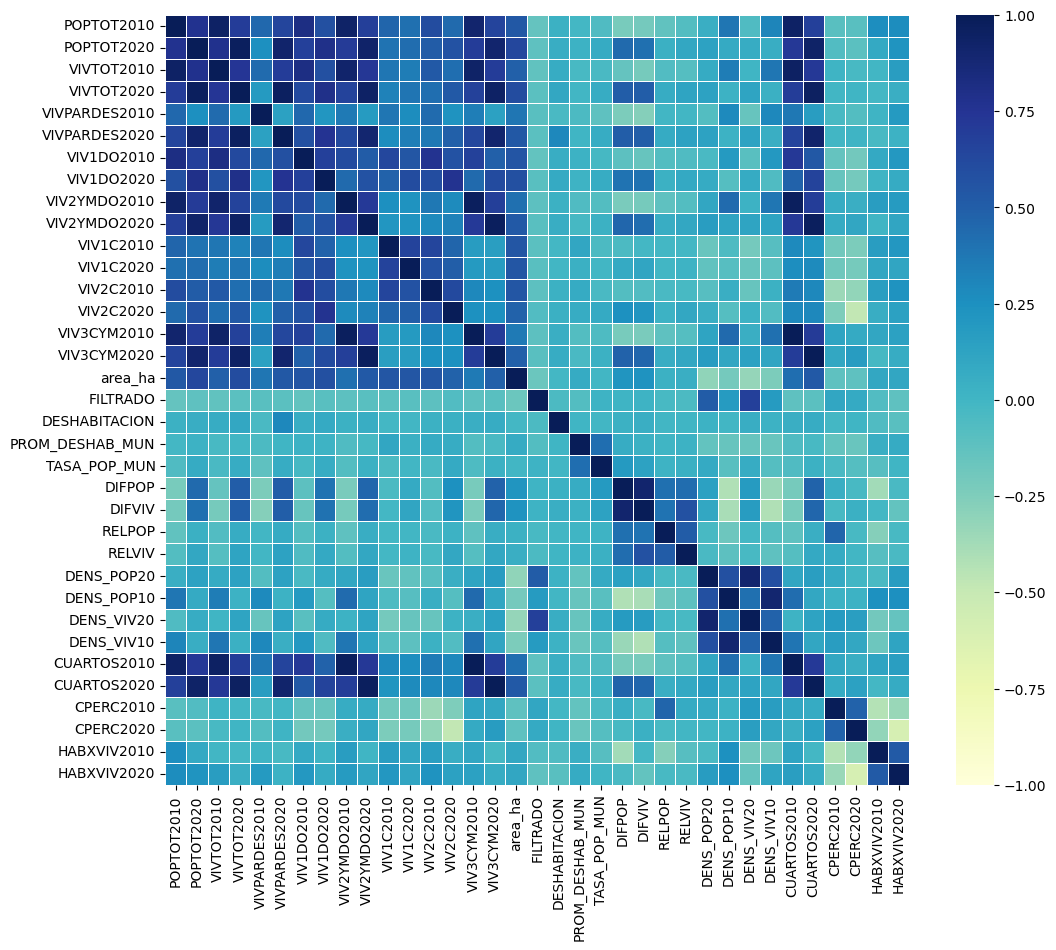

In [8]:
#df a analizar
MAPA_CM_f = MAPA_df_b

# Filtrar solo las columnas numéricas
MAPA_CM_f_numeric = MAPA_CM_f.select_dtypes(include=[np.number])

# Completa
correlaciones = MAPA_CM_f_numeric.corr()
display(correlaciones)

# Crear el heatmap de correlación
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlaciones, vmin=-1, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5)
plt.show()

POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010         1.000000    0.599678    0.909413    0.495693   
POPTOT2020         0.599678    1.000000    0.598710    0.950449   
VIVTOT2010         0.909413    0.598710    1.000000    0.541352   
VIVTOT2020         0.495693    0.950449    0.541352    1.000000   
VIVPARDES2010      0.492373    0.126744    0.499193    0.063879   
VIVPARDES2020      0.425464    0.865742    0.474273    0.949398   
VIV1DO2010         0.803077    0.513203    0.802136    0.443136   
VIV1DO2020         0.388305    0.748053    0.430836    0.771344   
VIV2YMDO2010       0.921704    0.526958    0.861738    0.460412   
VIV2YMDO2020       0.525495    0.900765    0.546961    0.898704   
VIV1C2010          0.343414    0.232162    0.272503    0.158202   
VIV1C2020          0.263454    0.267845    0.212716    0.230111   
VIV2C2010          0.528610    0.359586    0.490316    0.269032   
VIV2C2020          0.179550    0.427504    0.205088    0.412155   
VIV3CYM2010        0.909602    0.523816    0.884077    0.474085   
VIV3CYM2020        0.502939    0.889142    0.539143    0.910163   
area_ha            0.313003    0.466202    0.282291    0.462214   
FILTRADO          -0.085150   -0.030745   -0.085683   -0.013134   
DESHABITACION     -0.153315   -0.135610   -0.127480   -0.056940   
PROM_DESHAB_MUN   -0.037341    0.011468   -0.065514   -0.025688   
TASA_POP_MUN      -0.104936    0.104539   -0.093243    0.097529   
DIFPOP            -0.414902    0.479305   -0.316653    0.537009   
DIFVIV            -0.334065    0.469247   -0.371446    0.579558   
RELPOP            -0.153609    0.054742   -0.086426    0.058876   
RELVIV            -0.159042    0.043199   -0.175014    0.050584   
DENS_POP20        -0.049883    0.159407   -0.035713    0.164289   
DENS_POP10         0.545402    0.118052    0.485949    0.040108   
DENS_VIV20        -0.113017    0.100035   -0.080190    0.152160   
DENS_VIV10         0.440528    0.106334    0.556588    0.072180   
CUARTOS2010        0.934091    0.541615    0.901295    0.484615   
CUARTOS2020        0.524825    0.908529    0.555805    0.925709   
CPERC2010         -0.136169   -0.115843   -0.027024   -0.033526   
CPERC2020         -0.085104   -0.137943   -0.036432   -0.032783   
HABXVIV2010        0.302298    0.087876   -0.070816   -0.043347   
HABXVIV2020        0.297607    0.270249    0.175385    0.051025   

                 VIVPARDES2010  VIVPARDES2020  VIV1DO2010  VIV1DO2020  \
POPTOT2010            0.492373       0.425464    0.803077    0.388305   
POPTOT2020            0.126744       0.865742    0.513203    0.748053   
VIVTOT2010            0.499193       0.474273    0.802136    0.430836   
VIVTOT2020            0.063879       0.949398    0.443136    0.771344   
VIVPARDES2010         1.000000       0.042890    0.439509    0.050039   
VIVPARDES2020         0.042890       1.000000    0.397403    0.720350   
VIV1DO2010            0.439509       0.397403    1.000000    0.493052   
VIV1DO2020            0.050039       0.720350    0.493052    1.000000   
VIV2YMDO2010          0.431881       0.392157    0.581022    0.258568   
VIV2YMDO2020          0.098943       0.816632    0.359520    0.467752   
VIV1C2010             0.291068       0.147989    0.509508    0.268131   
VIV1C2020             0.182054       0.210842    0.347661    0.414927   
VIV2C2010             0.365851       0.238632    0.715451    0.399552   
VIV2C2020             0.025429       0.398547    0.333161    0.705823   
VIV3CYM2010           0.407717       0.408134    0.659054    0.287277   
VIV3CYM2020           0.066742       0.827770    0.357919    0.553050   
area_ha               0.295004       0.461170    0.305173    0.362274   
FILTRADO             -0.107991       0.001446   -0.076601   -0.002459   
DESHABITACION        -0.075976       0.187696   -0.089151   -0.068920   
PROM_DESHAB_MUN      -0.040732      -0.019653    0.001526    0.003900   
TASA_POP_MUN         -0.168219       0.104799   -0.078190    0.072666  

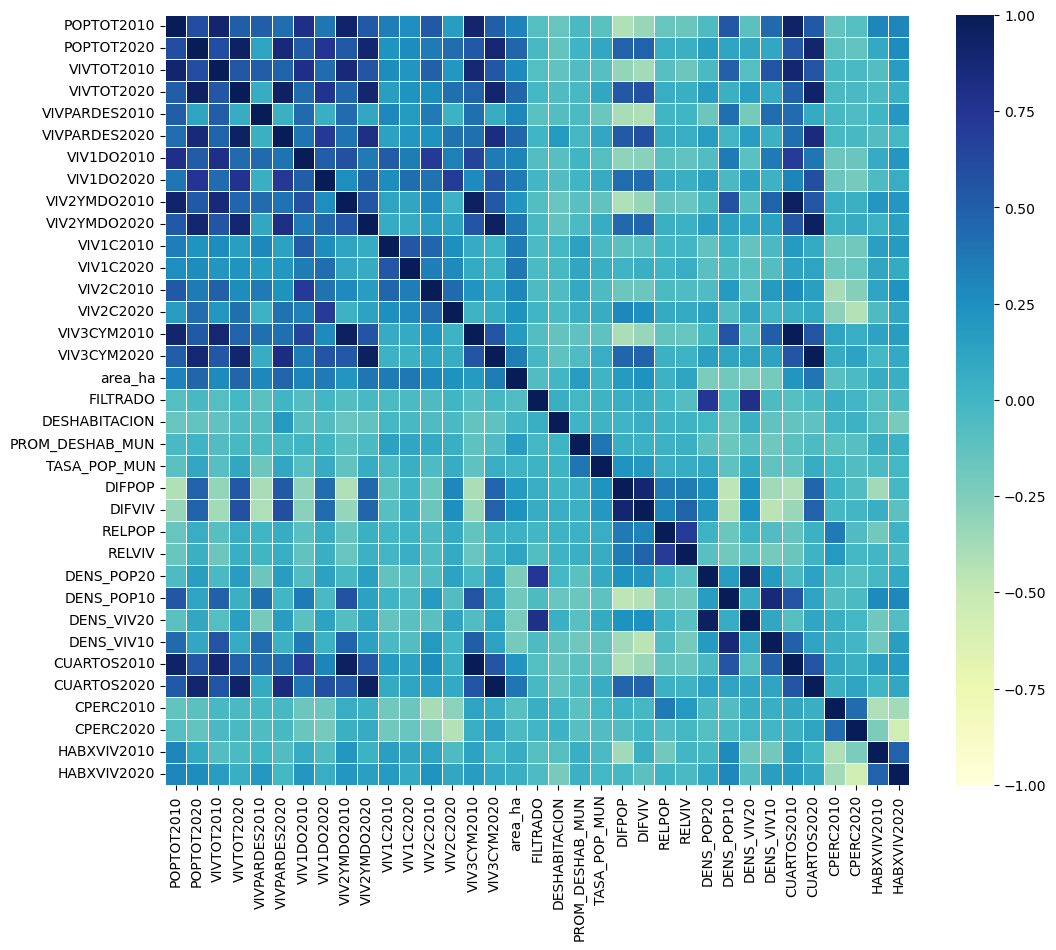

In [9]:
#df a analizar
MAPA_CM_f = MAPA_df_c

# Filtrar solo las columnas numéricas
MAPA_CM_f_numeric = MAPA_CM_f.select_dtypes(include=[np.number])

# Completa
correlaciones = MAPA_CM_f_numeric.corr()
display(correlaciones)

# Crear el heatmap de correlación
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlaciones, vmin=-1, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5)
plt.show()

POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010         1.000000    0.508881    0.890475    0.377757   
POPTOT2020         0.508881    1.000000    0.463980    0.894314   
VIVTOT2010         0.890475    0.463980    1.000000    0.413966   
VIVTOT2020         0.377757    0.894314    0.413966    1.000000   
VIVPARDES2010      0.523330    0.051523    0.542234   -0.043538   
VIVPARDES2020      0.237746    0.721689    0.279889    0.928171   
VIV1DO2010         0.838348    0.424574    0.843216    0.347426   
VIV1DO2020         0.399975    0.764177    0.417029    0.735360   
VIV2YMDO2010       0.906169    0.438114    0.872813    0.374444   
VIV2YMDO2020       0.419207    0.908282    0.423986    0.887823   
VIV1C2010          0.371099    0.143873    0.331930    0.067130   
VIV1C2020          0.181677    0.162245    0.107662    0.063761   
VIV2C2010          0.542410    0.291836    0.490418    0.174387   
VIV2C2020          0.210426    0.474589    0.210289    0.386465   
VIV3CYM2010        0.899625    0.432769    0.896654    0.386864   
VIV3CYM2020        0.416413    0.897182    0.437358    0.907413   
area_ha            0.196375    0.265950    0.167743    0.268396   
FILTRADO          -0.066253    0.046360   -0.070722    0.043730   
DESHABITACION     -0.302929   -0.424672   -0.313372   -0.340642   
PROM_DESHAB_MUN   -0.075155   -0.065620   -0.101285   -0.091495   
TASA_POP_MUN      -0.104395    0.055796   -0.111459    0.061267   
DIFPOP            -0.398014    0.587172   -0.342876    0.597843   
DIFVIV            -0.190143    0.647587   -0.224506    0.794117   
RELPOP            -0.174118    0.115935   -0.098720    0.074498   
RELVIV            -0.115803    0.078909   -0.145554    0.095682   
DENS_POP20        -0.005785    0.360358   -0.006931    0.306140   
DENS_POP10         0.428989    0.139373    0.363715    0.053116   
DENS_VIV20        -0.046721    0.339989   -0.029466    0.371732   
DENS_VIV10         0.456599    0.193905    0.556219    0.128664   
CUARTOS2010        0.922495    0.439170    0.914409    0.384420   
CUARTOS2020        0.435356    0.914079    0.448577    0.914033   
CPERC2010         -0.293279   -0.287634   -0.203480   -0.215869   
CPERC2020         -0.189789   -0.316066   -0.162015   -0.238334   
HABXVIV2010        0.158210    0.139629   -0.090844   -0.075742   
HABXVIV2020        0.127567    0.122255   -0.021895   -0.065567   

                 VIVPARDES2010  VIVPARDES2020  VIV1DO2010  VIV1DO2020  \
POPTOT2010            0.523330       0.237746    0.838348    0.399975   
POPTOT2020            0.051523       0.721689    0.424574    0.764177   
VIVTOT2010            0.542234       0.279889    0.843216    0.417029   
VIVTOT2020           -0.043538       0.928171    0.347426    0.735360   
VIVPARDES2010         1.000000      -0.107164    0.488647    0.044802   
VIVPARDES2020        -0.107164       1.000000    0.231322    0.570955   
VIV1DO2010            0.488647       0.231322    1.000000    0.434009   
VIV1DO2020            0.044802       0.570955    0.434009    1.000000   
VIV2YMDO2010          0.481957       0.238859    0.677515    0.328255   
VIV2YMDO2020          0.008186       0.736134    0.326823    0.555923   
VIV1C2010             0.375291       0.037702    0.543234    0.173728   
VIV1C2020             0.146302       0.010102    0.226382    0.314437   
VIV2C2010             0.420048       0.086925    0.647977    0.337027   
VIV2C2020             0.061172       0.273220    0.275641    0.670878   
VIV3CYM2010           0.464653       0.254750    0.754240    0.341171   
VIV3CYM2020          -0.014718       0.753859    0.334638    0.658998   
area_ha               0.080090       0.274661    0.170474    0.159468   
FILTRADO             -0.069974       0.026982   -0.060051    0.040762   
DESHABITACION        -0.145847      -0.158985   -0.254501   -0.349315   
PROM_DESHAB_MUN      -0.084302      -0.087858   -0.061920   -0.037054   
TASA_POP_MUN         -0.176792       0.058376   -0.080980    0.053936  

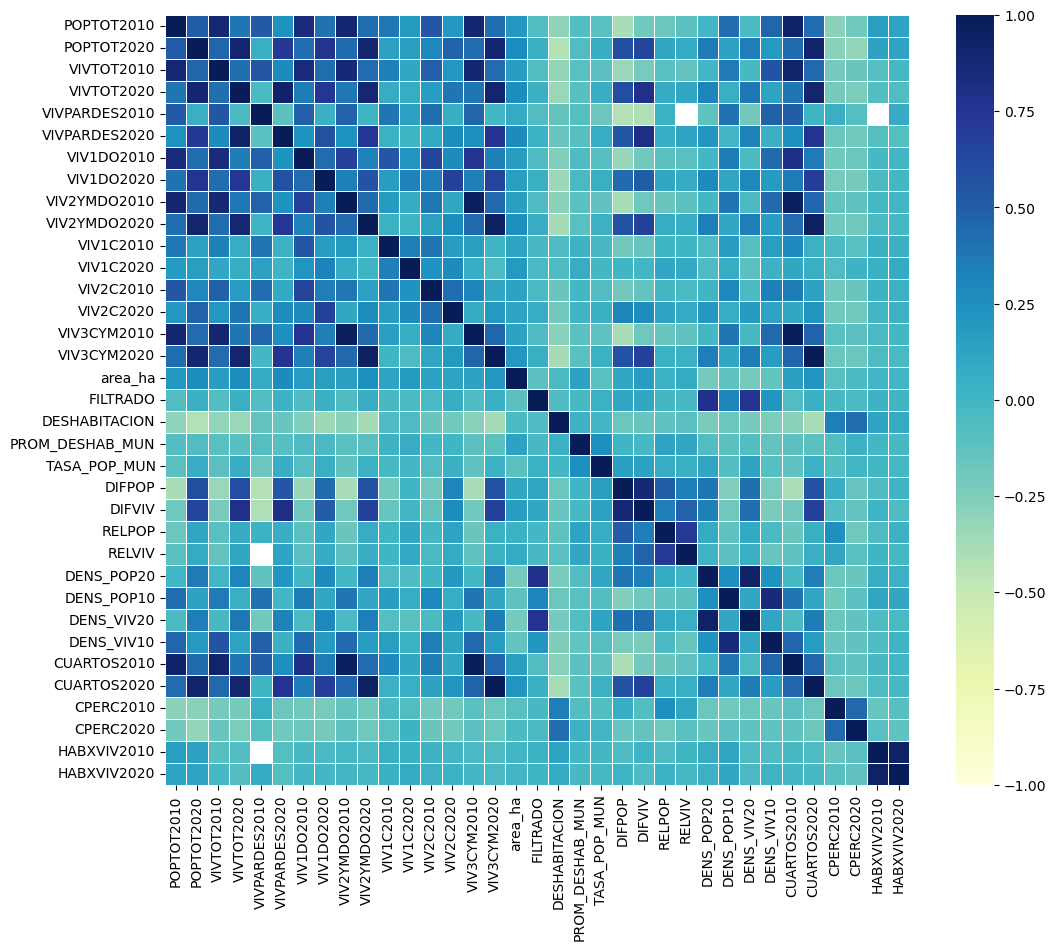

In [10]:
#df a analizar
MAPA_CM_f = MAPA_df_d

# Filtrar solo las columnas numéricas
MAPA_CM_f_numeric = MAPA_CM_f.select_dtypes(include=[np.number])

# Completa
correlaciones = MAPA_CM_f_numeric.corr()
display(correlaciones)

# Crear el heatmap de correlación
plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlaciones, vmin=-1, vmax=1, annot=False, cmap="YlGnBu", linewidths=.5)
plt.show()

## Análisis factorial

In [109]:
# Nombre del archivo y nombre de la pestaña donde deseas guardar los datos
excel_file = r"C:\Users\Alejandro\Downloads\DATA\Factorial\Test Mérida\Mérida_Factorial.xlsx"

### Rango a

In [110]:
sheet_name = 'Deshab A'

C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\factor_analyzer.py:109: RuntimeWarning: invalid value encountered in log
  statistic = -np.log(corr_det) * (n - 1 - (2 * p + 5) / 6)
C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


Chi square
nan nan

Modelo KMO
0.7020148689998534

Valores propios
[ 1.20021439e+01  5.92835079e+00  3.23582278e+00  2.54524010e+00
  1.94258658e+00  1.44472399e+00  1.34764559e+00  1.13772961e+00
  9.61524553e-01  7.13733340e-01  6.40861905e-01  4.63850706e-01
  4.04309294e-01  3.42179783e-01  3.24592133e-01  2.96507239e-01
  2.31346280e-01  2.15437853e-01  2.05638922e-01  1.58495231e-01
  1.17016791e-01  1.00211798e-01  7.63845612e-02  5.36776143e-02
  3.34001228e-02  3.08497663e-02  2.50414692e-02  1.00982492e-02
  8.13251824e-03  1.46469124e-03  1.00188180e-03  1.00679797e-15
  7.20417263e-16 -2.71871435e-17 -1.03835052e-16]


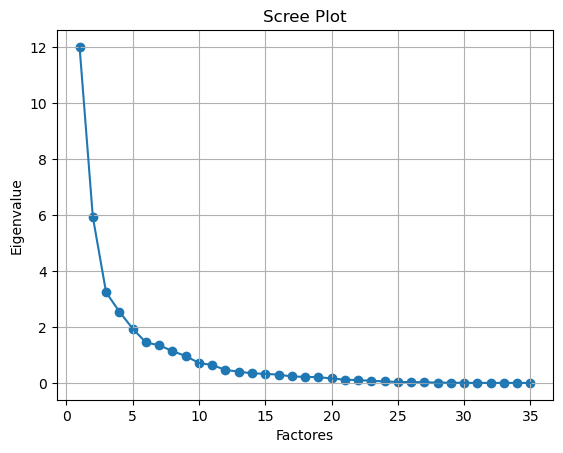

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.848041  0.429220  0.063340 -0.198086  0.170209 -0.098060   
POPTOT2020       0.830854  0.461971  0.026475  0.219799  0.127483 -0.003685   
VIVTOT2010       0.886917  0.362288  0.093251 -0.184457 -0.103788 -0.056887   
VIVTOT2020       0.872248  0.410192  0.030961  0.230192 -0.085078 -0.012546   
VIVPARDES2010    0.163556  0.728140  0.027924  0.081310  0.002728  0.036853   
VIVPARDES2020    0.672888  0.383602 -0.031933  0.215509 -0.245085 -0.074252   
VIV1DO2010       0.421233  0.729589 -0.032676 -0.088206 -0.039803 -0.087216   
VIV1DO2020       0.467309  0.696135 -0.067638  0.138203 -0.094041 -0.026435   
VIV2YMDO2010     0.924062  0.104143  0.134479 -0.222935  0.060246 -0.050605   
VIV2YMDO2020     0.926672  0.153953  0.089752  0.237291  0.014972  0.010053   
VIV1C2010        0.101986  0.854453 -0.085211  0.029237  0.082082  0.007749   
VIV1C2020        0.125290  0.809599 -0.104064  0.094104  0.054548 -0.006059   
VIV2C2010        0.180187  0.761951 -0.109038 -0.004618  0.107368 -0.100437   
VIV2C2020        0.210893  0.736611 -0.080040  0.083889  0.035605 -0.025923   
VIV3CYM2010      0.939960 -0.035482  0.158269 -0.247569 -0.032383 -0.044740   
VIV3CYM2020      0.952325  0.058832  0.092511  0.236147 -0.058561  0.005654   
area_ha          0.405114  0.589089 -0.317334  0.218032  0.065281  0.046344   
FILTRADO        -0.143199 -0.035409  0.731917  0.038740 -0.002584  0.003600   
DESHABITACION    0.205474  0.061727  0.006440  0.019762 -0.290710 -0.118264   
PROM_DESHAB_MUN -0.066977  0.020998 -0.137322  0.021027  0.056857 -0.000419   
TASA_POP_MUN     0.000626  0.019963  0.040198  0.022331  0.008434  0.012398   
DIFPOP           0.029203  0.114463 -0.082069  0.869712 -0.076326  0.204567   
DIFVIV           0.069679  0.156574 -0.138488  0.875804  0.021885  0.106820   
RELPOP          -0.064290  0.009115 -0.051487  0.083507 -0.086646  0.965656   
RELVIV          -0.086132  0.007525 -0.136716  0.203872  0.032529  0.555051   
DENS_POP20       0.172726 -0.103684  0.948058  0.039514  0.100638 -0.018941   
DENS_POP10       0.219857 -0.092015  0.888680 -0.242900  0.145943 -0.122200   
DENS_VIV20       0.166874 -0.112027  0.950967  0.025509 -0.168946 -0.028752   
DENS_VIV10       0.197728 -0.094154  0.911788 -0.230488 -0.162958 -0.061197   
CUARTOS2010      0.936780  0.128385  0.141929 -0.239005 -0.014718 -0.040798   
CUARTOS2020      0.939675  0.172190  0.077793  0.242088 -0.048362  0.005341   
CPERC2010        0.079732 -0.211575  0.107272 -0.035214 -0.386082  0.577493   
CPERC2020        0.110366 -0.262981  0.110665 -0.021650 -0.490024  0.033362   
HABXVIV2010      0.055012  0.064364 -0.050392 -0.078694  0.692448 -0.215327   
HABXVIV2020      0.016677  0.062781  0.000914  0.050000  0.745052  0.012054   

                       A7  
POPTOT2010       0.052729  
POPTOT2020       0.139395  
VIVTOT2010       0.095678  
VIVTOT2020       0.081866  
VIVPARDES2010   -0.224206  
VIVPARDES2020    0.136067  
VIV1DO2010       0.259574  
VIV1DO2020       0.220631  
VIV2YMDO2010    -0.119670  
VIV2YMDO2020    -0.041390  
VIV1C2010       -0.008125  
VIV1C2020        0.009758  
VIV2C2010        0.283701  
VIV2C2020        0.397252  
VIV3CYM2010     -0.070004  
VIV3CYM2020     -0.074887  
area_ha         -0.093953  
FILTRADO        -0.098343  
DESHABITACION    0.211163  
PROM_DESHAB_MUN  0.162310  
TASA_POP_MUN     0.188664  
DIFPOP           0.182746  
DIFVIV          -0.004492  
RELPOP           0.153485  
RELVIV          -0.019839  
DENS_POP20       0.117713  
DENS_POP10      -0.027778  
DENS_VIV20       0.031582  
DENS_VIV10       0.017703  
CUARTOS2010     -0.078359  
CUARTOS2020     -0.078320  
CPERC2010       -0.321726  
CPERC2020       -0.674367  
HABXVIV2010      0.026912  
HABXVIV2020      0.318825

A1        A2        A3        A4        A5        A6  \
SS Loadings     9.614467  5.538829  4.298869  2.357137  1.784382  1.756563   
Proportion Var  0.274699  0.158252  0.122825  0.067347  0.050982  0.050188   
Cumulative Var  0.274699  0.432951  0.555776  0.623123  0.674105  0.724293   

                      A7  
SS Loadings     1.359166  
Proportion Var  0.038833  
Cumulative Var  0.763126

In [111]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_a

#hacer CVEGEO index y borrar columnas

MAPA_df_f = MAPA_df_f.drop(columns=[ 'CVEPOP', 'CVEVIV', 'TIPOLOGIA', 'R_DESHAB',
       'SUBTIPOLOGÍA'])

MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

In [112]:
# Escribir los loadings en la pestaña especificada del archivo Excel
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    loadings_df.to_excel(writer, sheet_name=sheet_name, startrow=0, index=True)
        
    # Agregar título a la tabla de loadings
    worksheet = writer.sheets[sheet_name]
    worksheet.cell(row=1, column=1, value='Loadings')

print("El archivo Excel ha sido creado y los loadings han sido guardados exitosamente.")


El archivo Excel ha sido creado y los loadings han sido guardados exitosamente.


#### filtro

In [56]:
# Check for highly correlated variables
correlation_matrix = MAPA_df_f.corr()
highly_correlated = (correlation_matrix > 0.95) & (correlation_matrix < 1.0)

print("Highly Correlated Variables:\n", highly_correlated)

# Drop one of each pair of highly correlated variables
variables_to_drop = set()
for var in highly_correlated.columns:
    variables_to_drop.update(set(highly_correlated.index[highly_correlated[var]]))
MAPA_df_f_fil = MAPA_df_f.drop(columns=variables_to_drop)


Highly Correlated Variables:
                  POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010            False       False       False       False   
POPTOT2020            False       False       False        True   
VIVTOT2010            False       False       False       False   
VIVTOT2020            False        True       False       False   
VIVPARDES2010         False       False       False       False   
VIVPARDES2020         False       False       False       False   
VIV1DO2010            False       False       False       False   
VIV1DO2020            False       False       False       False   
VIV2YMDO2010          False       False       False       False   
VIV2YMDO2020          False       False       False       False   
VIV1C2010             False       False       False       False   
VIV1C2020             False       False       False       False   
VIV2C2010             False       False       False       False   
VIV2C2020             False     

Chi square
203245.71423754268 0.0

Modelo KMO
0.7293093715455325

Valores propios
[7.28545893 4.74918681 2.78678128 2.11285859 1.41775272 1.33012191
 1.25104575 0.99334816 0.88931929 0.70600417 0.6403256  0.45998247
 0.37631092 0.32318582 0.29826619 0.28588119 0.22014925 0.2065627
 0.15888711 0.1511026  0.09778031 0.08682969 0.07204758 0.05201852
 0.03101579 0.01029464 0.00748202]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


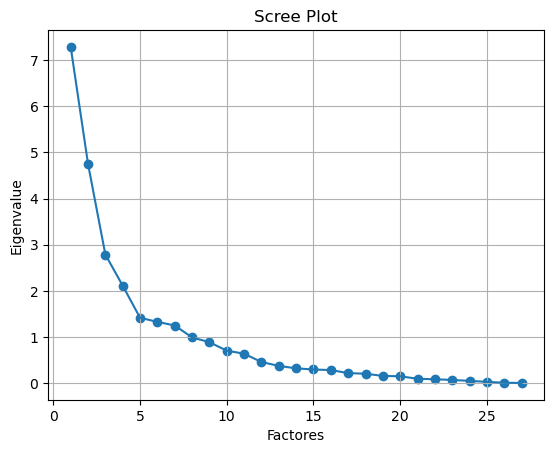

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.569578  0.149551  0.670321 -0.225107 -0.035965  0.302873   
VIVTOT2010       0.517186  0.182970  0.726917 -0.218464 -0.014243  0.021084   
VIVPARDES2010    0.746648  0.030122  0.006339  0.085713  0.023028  0.006674   
VIVPARDES2020    0.441796  0.024223  0.771756  0.240825 -0.008383 -0.026986   
VIV1DO2010       0.782458  0.002046  0.359643 -0.102543 -0.075049 -0.007489   
VIV1DO2020       0.757738 -0.024585  0.402557  0.140177 -0.008619 -0.033213   
VIV1C2010        0.851507 -0.089173 -0.014489  0.031445 -0.007985  0.050761   
VIV1C2020        0.813818 -0.101514  0.019376  0.113164 -0.017065  0.046542   
VIV2C2010        0.763642 -0.100767  0.144929 -0.019906 -0.094208  0.087670   
VIV2C2020        0.743570 -0.064154  0.193331  0.095497 -0.030402  0.001363   
area_ha          0.654634 -0.280044  0.275999  0.202134  0.066668  0.115339   
FILTRADO        -0.064780  0.708929 -0.195486  0.052922 -0.015244 -0.034370   
DESHABITACION    0.030077  0.019095  0.438944  0.063169 -0.071256 -0.118400   
PROM_DESHAB_MUN  0.005645 -0.141588 -0.028527  0.024722 -0.003103  0.025799   
TASA_POP_MUN     0.015171  0.041515  0.024148  0.020552  0.008533 -0.021777   
DIFPOP           0.130022 -0.082862  0.032304  0.788165  0.190239 -0.166829   
DIFVIV           0.156323 -0.125188  0.072894  0.944314  0.126589  0.088805   
RELPOP           0.000290 -0.054319 -0.056007  0.075893  0.961408 -0.144876   
RELVIV          -0.007842 -0.141059 -0.090170  0.222383  0.586468  0.059810   
DENS_POP20      -0.075945  0.963388  0.080912  0.028794 -0.015663  0.073358   
DENS_POP10      -0.060881  0.913144  0.113191 -0.237738 -0.097968  0.206146   
DENS_VIV20      -0.090603  0.962377  0.118219  0.029450 -0.027789 -0.135172   
DENS_VIV10      -0.063951  0.926540  0.136756 -0.235798 -0.064800 -0.140782   
CPERC2010       -0.173133  0.116326  0.026520 -0.024646  0.549301 -0.354325   
CPERC2020       -0.217361  0.117099  0.052747 -0.022158  0.037825 -0.321649   
HABXVIV2010      0.063687 -0.036249 -0.051726 -0.052738 -0.155974  0.890789   
HABXVIV2020      0.082903  0.007636 -0.101152  0.007081  0.007938  0.542285   

                       A7  
POPTOT2010      -0.043526  
VIVTOT2010      -0.048177  
VIVPARDES2010   -0.177449  
VIVPARDES2020   -0.067509  
VIV1DO2010       0.197167  
VIV1DO2020       0.139322  
VIV1C2010        0.049415  
VIV1C2020        0.042183  
VIV2C2010        0.288302  
VIV2C2020        0.381802  
area_ha         -0.093130  
FILTRADO        -0.063528  
DESHABITACION    0.028051  
PROM_DESHAB_MUN  0.177520  
TASA_POP_MUN     0.184575  
DIFPOP           0.214171  
DIFVIV          -0.022990  
RELPOP           0.139309  
RELVIV          -0.027917  
DENS_POP20       0.119561  
DENS_POP10      -0.058915  
DENS_VIV20      -0.038131  
DENS_VIV10      -0.048469  
CPERC2010       -0.383776  
CPERC2020       -0.811750  
HABXVIV2010      0.073288  
HABXVIV2020      0.486714

A1        A2        A3        A4        A5        A6  \
SS Loadings     5.639621  4.314209  2.318260  1.951796  1.690629  1.599019   
Proportion Var  0.208875  0.159786  0.085861  0.072289  0.062616  0.059223   
Cumulative Var  0.208875  0.368660  0.454522  0.526811  0.589426  0.648649   

                      A7  
SS Loadings     1.547372  
Proportion Var  0.057310  
Cumulative Var  0.705959

In [58]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_f_fil

#hacer CVEGEO index y borrar columnas

# MAPA_df_f = MAPA_df_f.drop(columns=['CVE_ENT', 'CVE_MUN', 'NOM_MUN'])

# MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

### Rango b

In [113]:
sheet_name = 'Deshab B'

Chi square
651168.816859188 0.0

Modelo KMO
0.7142911507882673

Valores propios
[ 1.29957646e+01  5.37058153e+00  3.17800725e+00  2.62046479e+00
  1.78935751e+00  1.39097483e+00  1.13231248e+00  9.83912291e-01
  9.17162653e-01  7.95410794e-01  6.20776209e-01  5.85323805e-01
  4.37868521e-01  3.93436648e-01  3.13726314e-01  2.84339992e-01
  2.43986196e-01  2.28273431e-01  1.83939547e-01  1.41047332e-01
  1.28478132e-01  9.14551408e-02  4.99396930e-02  3.72892334e-02
  2.92439022e-02  2.30684528e-02  1.78410545e-02  8.60674027e-03
  6.08596347e-03  8.42751617e-04  4.82200853e-04  1.46335942e-15
  9.26228335e-17 -2.46020566e-16 -6.80427151e-16]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


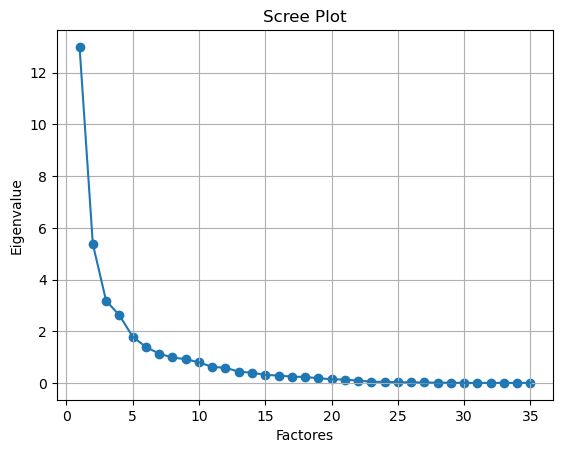

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.881982  0.410547  0.022442 -0.111538  0.143090 -0.103544   
POPTOT2020       0.861886  0.418077  0.001544  0.177402  0.145786  0.143157   
VIVTOT2010       0.915791  0.334450  0.043818 -0.111120 -0.019180  0.166988   
VIVTOT2020       0.883835  0.385593  0.004100  0.200390 -0.015864  0.170512   
VIVPARDES2010    0.124968  0.422386 -0.014140  0.104688 -0.061129 -0.033508   
VIVPARDES2020    0.855437  0.315327  0.001212  0.205278 -0.022986  0.223151   
VIV1DO2010       0.563765  0.693482 -0.036959 -0.115865  0.089169  0.125313   
VIV1DO2020       0.550177  0.700834 -0.056592  0.117813  0.045446  0.186638   
VIV2YMDO2010     0.948085  0.115878  0.080635 -0.101762 -0.004251 -0.124393   
VIV2YMDO2020     0.939407  0.150966  0.049466  0.189751 -0.009401  0.106001   
VIV1C2010        0.127339  0.757391 -0.144024  0.004012  0.130747 -0.098135   
VIV1C2020        0.181729  0.762678 -0.110797  0.086303  0.051055 -0.066144   
VIV2C2010        0.220756  0.796101 -0.071474 -0.043985  0.221201  0.074193   
VIV2C2020        0.301010  0.725342 -0.048983  0.064562  0.227620  0.247136   
VIV3CYM2010      0.976544  0.047697  0.091245 -0.128320 -0.051349 -0.039684   
VIV3CYM2020      0.956684  0.103093  0.046232  0.190860 -0.068717  0.112851   
area_ha          0.422190  0.595063 -0.309665  0.193785  0.008019 -0.038353   
FILTRADO        -0.186140 -0.055328  0.735108  0.032428 -0.086009 -0.020769   
DESHABITACION    0.087374  0.012152  0.011618 -0.004629 -0.052684  0.112981   
PROM_DESHAB_MUN -0.025358  0.050114 -0.154150  0.017035  0.209673  0.187597   
TASA_POP_MUN     0.056429 -0.011670  0.046030  0.040236  0.110208  0.274736   
DIFPOP           0.147881  0.123118 -0.050132  0.678376  0.031828  0.548695   
DIFVIV           0.165994  0.255016 -0.113445  0.913952  0.008101  0.065538   
RELPOP          -0.047814  0.003188 -0.039387  0.456400 -0.007569  0.025966   
RELVIV          -0.015534 -0.014326 -0.073315  0.599188  0.004628 -0.050016   
DENS_POP20       0.131697 -0.115224  0.955831 -0.009785  0.133294  0.091327   
DENS_POP10       0.172242 -0.120294  0.906524 -0.134946  0.102718 -0.237569   
DENS_VIV20       0.116730 -0.104886  0.958992 -0.018820 -0.143476  0.135484   
DENS_VIV10       0.127989 -0.102178  0.938054 -0.168629 -0.149516  0.113213   
CUARTOS2010      0.968393  0.151406  0.072745 -0.126465 -0.036030 -0.058475   
CUARTOS2020      0.944097  0.192245  0.034383  0.195347 -0.064673  0.096284   
CPERC2010        0.091227 -0.218288  0.082060  0.027662 -0.467520 -0.041541   
CPERC2020        0.142201 -0.292773  0.089458  0.021699 -0.814132 -0.223947   
HABXVIV2010      0.076624  0.039362 -0.047551  0.025758  0.593845 -0.604807   
HABXVIV2020      0.051904  0.048740  0.035977  0.020098  0.776160 -0.066507   

                       A7  
POPTOT2010      -0.038855  
POPTOT2020       0.006129  
VIVTOT2010       0.019986  
VIVTOT2020       0.009280  
VIVPARDES2010   -0.032938  
VIVPARDES2020   -0.000085  
VIV1DO2010       0.003976  
VIV1DO2020      -0.017642  
VIV2YMDO2010    -0.027113  
VIV2YMDO2020     0.019461  
VIV1C2010        0.012569  
VIV1C2020       -0.030142  
VIV2C2010       -0.046189  
VIV2C2020       -0.005210  
VIV3CYM2010     -0.004400  
VIV3CYM2020      0.010672  
area_ha         -0.045481  
FILTRADO        -0.023033  
DESHABITACION   -0.025396  
PROM_DESHAB_MUN -0.033548  
TASA_POP_MUN    -0.010928  
DIFPOP           0.126222  
DIFVIV          -0.014932  
RELPOP           0.885818  
RELVIV           0.219317  
DENS_POP20       0.039777  
DENS_POP10      -0.082029  
DENS_VIV20       0.034880  
DENS_VIV10       0.027777  
CUARTOS2010      0.001136  
CUARTOS2020      0.007234  
CPERC2010        0.515432  
CPERC2020       -0.024581  
HABXVIV2010     -0.306573  
HABXVIV2020     -0.005854

A1        A2        A3        A4        A5        A6  \
SS Loadings     10.566842  4.904864  4.311529  2.296560  2.165241  1.275850   
Proportion Var   0.301910  0.140139  0.123187  0.065616  0.061864  0.036453   
Cumulative Var   0.301910  0.442049  0.565235  0.630851  0.692715  0.729168   

                      A7  
SS Loadings     1.231985  
Proportion Var  0.035200  
Cumulative Var  0.764368

In [114]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_b

#hacer CVEGEO index y borrar columnas

MAPA_df_f = MAPA_df_f.drop(columns=[ 'CVEPOP', 'CVEVIV', 'TIPOLOGIA', 'R_DESHAB',
       'SUBTIPOLOGÍA'])

MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

In [116]:
# Verificar si el archivo existe y cargarlo
if os.path.exists(excel_file):
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
        book = writer.book
        if sheet_name in book.sheetnames:
            print(f"La hoja {sheet_name} ya existe en el archivo {excel_file}.")
        else:
            loadings_df.to_excel(writer, sheet_name=sheet_name, startrow=0, index=True)
            
            # Agregar título a la tabla de loadings
            worksheet = writer.sheets[sheet_name]
            worksheet.cell(row=1, column=1, value='Loadings')
        print(f"Los loadings han sido guardados exitosamente en la nueva pestaña {sheet_name} del archivo Excel.")
else:
    print(f"El archivo {excel_file} no existe. Por favor, crea el archivo primero.")


Los loadings han sido guardados exitosamente en la nueva pestaña Deshab B del archivo Excel.


#### filtro

In [60]:
# Check for highly correlated variables
correlation_matrix = MAPA_df_f.corr()
highly_correlated = (correlation_matrix > 0.95) & (correlation_matrix < 1.0)

print("Highly Correlated Variables:\n", highly_correlated)

# Drop one of each pair of highly correlated variables
variables_to_drop = set()
for var in highly_correlated.columns:
    variables_to_drop.update(set(highly_correlated.index[highly_correlated[var]]))
MAPA_df_f_fil = MAPA_df_f.drop(columns=variables_to_drop)


Highly Correlated Variables:
                  POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010            False       False       False       False   
POPTOT2020            False       False       False        True   
VIVTOT2010            False       False       False       False   
VIVTOT2020            False        True       False       False   
VIVPARDES2010         False       False       False       False   
VIVPARDES2020         False       False       False        True   
VIV1DO2010            False       False       False       False   
VIV1DO2020            False       False       False       False   
VIV2YMDO2010          False       False       False       False   
VIV2YMDO2020          False       False       False       False   
VIV1C2010             False       False       False       False   
VIV1C2020             False       False       False       False   
VIV2C2010             False       False       False       False   
VIV2C2020             False     

Chi square
69883.99353734334 0.0

Modelo KMO
0.7076519475766768

Valores propios
[6.77526956 3.03151305 2.5092063  2.09317066 1.38042314 1.13396099
 1.02940669 0.970062   0.87093756 0.78042157 0.59838876 0.56862027
 0.41171424 0.37973864 0.28350073 0.26586861 0.22795392 0.19624915
 0.1448121  0.11570706 0.10790382 0.08035818 0.03664213 0.00817087]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


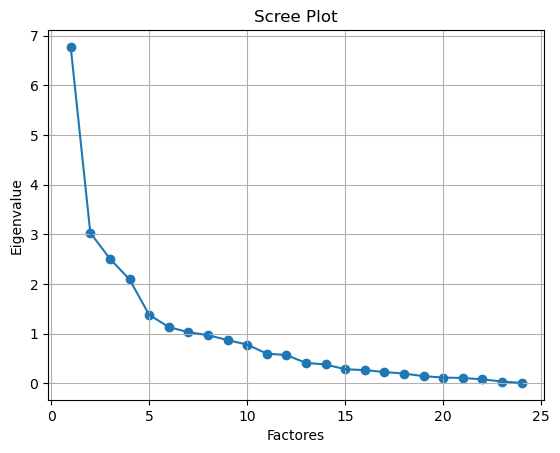

A1        A2        A3        A4        A5        A6
POPTOT2010       0.566542  0.072221 -0.072457  0.754522  0.002618  0.273232
VIVTOT2010       0.485414  0.075030 -0.021026  0.863768 -0.026069 -0.003251
VIVPARDES2010    0.457899  0.001320  0.075769  0.015284 -0.058206 -0.003216
VIV1DO2010       0.765274 -0.006404 -0.069110  0.476353  0.118697 -0.008889
VIV1DO2020       0.777658 -0.027442  0.157753  0.451952  0.115240 -0.039059
VIV1C2010        0.773089 -0.112546 -0.016494 -0.031100  0.109633  0.085102
VIV1C2020        0.795710 -0.085016  0.059002  0.013156  0.049875  0.060742
VIV2C2010        0.797630 -0.047316 -0.054918  0.134650  0.260181  0.036192
VIV2C2020        0.737018 -0.019875  0.103499  0.244304  0.334773 -0.068820
area_ha          0.697874 -0.253821  0.178120  0.233966 -0.001082  0.094264
FILTRADO        -0.094045  0.712525 -0.019331 -0.200475 -0.108458 -0.094943
DESHABITACION    0.012979 -0.012581  0.000826  0.109002 -0.006493 -0.053948
PROM_DESHAB_MUN  0.031808 -0.137810  0.029986  0.019454  0.295788 -0.037516
TASA_POP_MUN    -0.018898  0.057092  0.071077  0.119790  0.221818 -0.143093
DIFPOP           0.160849 -0.023677  0.712816  0.131388  0.232122 -0.305952
DIFVIV           0.315374 -0.081427  0.836442  0.022232  0.033713  0.092970
RELPOP          -0.045859 -0.029576  0.609090 -0.022573 -0.047171 -0.184930
RELVIV          -0.013076 -0.059088  0.674767 -0.076459 -0.047572  0.099828
DENS_POP20      -0.112679  0.973243 -0.003294  0.134598  0.079506 -0.056623
DENS_POP10      -0.093372  0.917034 -0.193945  0.116343 -0.098754  0.219401
CPERC2010       -0.209362  0.064305  0.208932  0.109410 -0.456185 -0.292190
CPERC2020       -0.219996  0.029641 -0.008108  0.110752 -0.861291 -0.131721
HABXVIV2010      0.085788  0.017719 -0.125580 -0.084317  0.228499  0.943446
HABXVIV2020      0.064102  0.123728  0.004139 -0.002457  0.607065  0.371194

A1        A2        A3        A4        A5        A6
SS Loadings     5.117024  2.449042  2.227803  2.034418  1.820465  1.464311
Proportion Var  0.213209  0.102043  0.092825  0.084767  0.075853  0.061013
Cumulative Var  0.213209  0.315253  0.408078  0.492845  0.568698  0.629711

In [61]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_f_fil

#hacer CVEGEO index y borrar columnas

# MAPA_df_f = MAPA_df_f.drop(columns=['CVE_ENT', 'CVE_MUN', 'NOM_MUN'])

# MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=6, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

### Rango c

In [117]:
sheet_name = 'Deshab C'

Chi square
599522.4277551026 0.0

Modelo KMO
0.6687589850255874

Valores propios
[ 1.13019962e+01  5.32093240e+00  3.21902841e+00  3.02755074e+00
  1.91769555e+00  1.28509129e+00  1.22897652e+00  1.14839629e+00
  1.06891096e+00  8.97502510e-01  7.44731783e-01  6.81589864e-01
  5.04128120e-01  4.18821342e-01  3.97097159e-01  3.44584423e-01
  2.84424235e-01  2.54501277e-01  2.22616974e-01  1.98738517e-01
  1.49306191e-01  1.32911798e-01  7.22771313e-02  5.23583817e-02
  4.16728126e-02  3.68824142e-02  2.47328625e-02  1.13539551e-02
  8.13194531e-03  1.84987593e-03  1.20806985e-03  1.05086837e-15
  8.34996410e-16 -7.19523600e-17 -6.73630992e-16]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


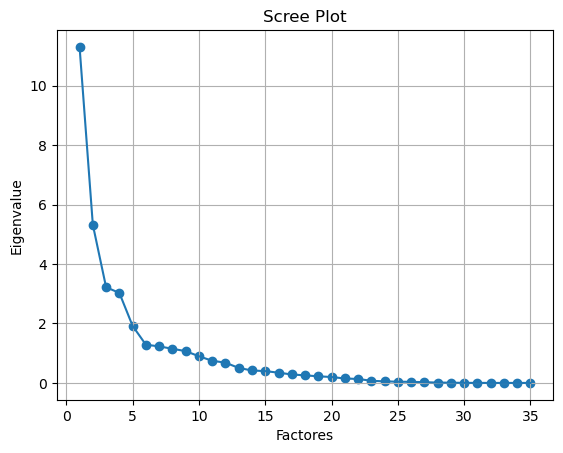

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.875941  0.036150  0.314142 -0.248873  0.216525 -0.069381   
POPTOT2020       0.858542  0.013179  0.342108  0.298000  0.168287  0.041418   
VIVTOT2010       0.899998  0.099242  0.348051 -0.032169 -0.101607 -0.100332   
VIVTOT2020       0.892052  0.024445  0.315558  0.260789 -0.072578  0.042456   
VIVPARDES2010    0.112012 -0.044750  0.142118  0.044688 -0.051273 -0.010302   
VIVPARDES2020    0.817378  0.003257  0.325707  0.216147 -0.152366  0.051148   
VIV1DO2010       0.560297 -0.001318  0.684047 -0.107907 -0.010088 -0.068199   
VIV1DO2020       0.550560 -0.015856  0.651957  0.198948 -0.073551  0.040871   
VIV2YMDO2010     0.910559  0.092970 -0.051316 -0.256503  0.111397 -0.051533   
VIV2YMDO2020     0.921559  0.071129  0.009104  0.249918  0.056718  0.035932   
VIV1C2010        0.038435 -0.196540  0.545655 -0.038889  0.078962  0.010057   
VIV1C2020        0.120034 -0.161052  0.494378  0.037873  0.033013  0.040486   
VIV2C2010        0.163982 -0.023539  0.757824  0.018493  0.131656 -0.073470   
VIV2C2020        0.155115  0.006486  0.778335  0.243765  0.056690  0.026978   
VIV3CYM2010      0.943300  0.108350 -0.055635 -0.252285  0.021780 -0.045365   
VIV3CYM2020      0.960138  0.067971 -0.025512  0.221896 -0.020876  0.030375   
area_ha          0.338608 -0.397334  0.306051  0.165741 -0.019777  0.012559   
FILTRADO        -0.173528  0.772345 -0.100000  0.027682 -0.030300 -0.013086   
DESHABITACION   -0.121485 -0.082953  0.026253 -0.021946 -0.185561 -0.002554   
PROM_DESHAB_MUN -0.073055 -0.200765  0.166517  0.114400  0.107548  0.006430   
TASA_POP_MUN     0.028368  0.011272  0.064030  0.174020  0.055100  0.034818   
DIFPOP           0.017340 -0.038921  0.069643  0.951338 -0.074674  0.198222   
DIFVIV           0.117625 -0.160754  0.005901  0.600817  0.044745  0.297674   
RELPOP          -0.037260 -0.009161  0.050619  0.189220 -0.079139  0.967418   
RELVIV          -0.042110 -0.090260 -0.052770  0.206170  0.031742  0.708294   
DENS_POP20       0.155901  0.938592  0.006679  0.113830  0.192447  0.016676   
DENS_POP10       0.200573  0.856629 -0.086788 -0.269422  0.268546 -0.079296   
DENS_VIV20       0.151851  0.965674 -0.010445  0.093099 -0.096564  0.009949   
DENS_VIV10       0.174527  0.925866  0.018560 -0.051718 -0.111541 -0.090498   
CUARTOS2010      0.944740  0.085678  0.022476 -0.265090  0.029218 -0.041500   
CUARTOS2020      0.953985  0.051661  0.036957  0.216509 -0.020216  0.036282   
CPERC2010        0.099763  0.017735 -0.347329 -0.071565 -0.450127  0.358001   
CPERC2020        0.151333  0.029138 -0.460465 -0.188017 -0.541082 -0.009048   
HABXVIV2010      0.005988 -0.110859 -0.056052 -0.288274  0.727067 -0.022659   
HABXVIV2020      0.037618  0.030103  0.133621  0.134859  0.804863  0.006556   

                       A7  
POPTOT2010       0.104294  
POPTOT2020       0.130512  
VIVTOT2010      -0.118787  
VIVTOT2020       0.161764  
VIVPARDES2010    0.276811  
VIVPARDES2020    0.193005  
VIV1DO2010       0.032729  
VIV1DO2020       0.132185  
VIV2YMDO2010     0.028593  
VIV2YMDO2020     0.108208  
VIV1C2010        0.340897  
VIV1C2020        0.440758  
VIV2C2010        0.068783  
VIV2C2020        0.012538  
VIV3CYM2010     -0.062309  
VIV3CYM2020      0.070140  
area_ha          0.429909  
FILTRADO         0.061330  
DESHABITACION    0.060740  
PROM_DESHAB_MUN  0.076056  
TASA_POP_MUN     0.002025  
DIFPOP           0.055832  
DIFVIV           0.515572  
RELPOP          -0.117637  
RELVIV           0.181310  
DENS_POP20      -0.122040  
DENS_POP10       0.037906  
DENS_VIV20      -0.090992  
DENS_VIV10      -0.203699  
CUARTOS2010     -0.003272  
CUARTOS2020      0.138625  
CPERC2010       -0.107305  
CPERC2020        0.146004  
HABXVIV2010      0.351317  
HABXVIV2020     -0.112977

A1        A2        A3        A4        A5        A6  \
SS Loadings     10.102673  4.375602  3.694384  2.395798  2.035748  1.756001   
Proportion Var   0.288648  0.125017  0.105554  0.068451  0.058164  0.050171   
Cumulative Var   0.288648  0.413665  0.519219  0.587670  0.645834  0.696006   

                      A7  
SS Loadings     1.305358  
Proportion Var  0.037296  
Cumulative Var  0.733302

In [118]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_c

#hacer CVEGEO index y borrar columnas

MAPA_df_f = MAPA_df_f.drop(columns=[ 'CVEPOP', 'CVEVIV', 'TIPOLOGIA', 'R_DESHAB',
       'SUBTIPOLOGÍA'])

MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

In [119]:
# Verificar si el archivo existe y cargarlo
if os.path.exists(excel_file):
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
        book = writer.book
        if sheet_name in book.sheetnames:
            print(f"La hoja {sheet_name} ya existe en el archivo {excel_file}.")
        else:
            loadings_df.to_excel(writer, sheet_name=sheet_name, startrow=0, index=True)
            
            # Agregar título a la tabla de loadings
            worksheet = writer.sheets[sheet_name]
            worksheet.cell(row=1, column=1, value='Loadings')
        print(f"Los loadings han sido guardados exitosamente en la nueva pestaña {sheet_name} del archivo Excel.")
else:
    print(f"El archivo {excel_file} no existe. Por favor, crea el archivo primero.")


Los loadings han sido guardados exitosamente en la nueva pestaña Deshab C del archivo Excel.


#### filtro

In [63]:
# Check for highly correlated variables
correlation_matrix = MAPA_df_f.corr()
highly_correlated = (correlation_matrix > 0.95) & (correlation_matrix < 1.0)

print("Highly Correlated Variables:\n", highly_correlated)

# Drop one of each pair of highly correlated variables
variables_to_drop = set()
for var in highly_correlated.columns:
    variables_to_drop.update(set(highly_correlated.index[highly_correlated[var]]))
MAPA_df_f_fil = MAPA_df_f.drop(columns=variables_to_drop)


Highly Correlated Variables:
                  POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010            False       False       False       False   
POPTOT2020            False       False       False        True   
VIVTOT2010            False       False       False       False   
VIVTOT2020            False        True       False       False   
VIVPARDES2010         False       False       False       False   
VIVPARDES2020         False       False       False       False   
VIV1DO2010            False       False       False       False   
VIV1DO2020            False       False       False       False   
VIV2YMDO2010          False       False       False       False   
VIV2YMDO2020          False       False       False       False   
VIV1C2010             False       False       False       False   
VIV1C2020             False       False       False       False   
VIV2C2010             False       False       False       False   
VIV2C2020             False     

Chi square
90222.91723404109 0.0

Modelo KMO
0.661107433154583

Valores propios
[5.91320206e+00 4.81077972e+00 2.80947301e+00 2.40813456e+00
 1.43219165e+00 1.23002981e+00 1.17482012e+00 1.06551195e+00
 1.05616629e+00 8.90582615e-01 7.27498728e-01 6.70458075e-01
 4.33352858e-01 4.05939833e-01 3.94745585e-01 3.33579513e-01
 2.48605473e-01 2.28671697e-01 2.14489401e-01 1.59942102e-01
 1.26950345e-01 1.06540927e-01 6.88383011e-02 4.20559834e-02
 2.92088713e-02 1.24864863e-02 5.74402568e-03]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


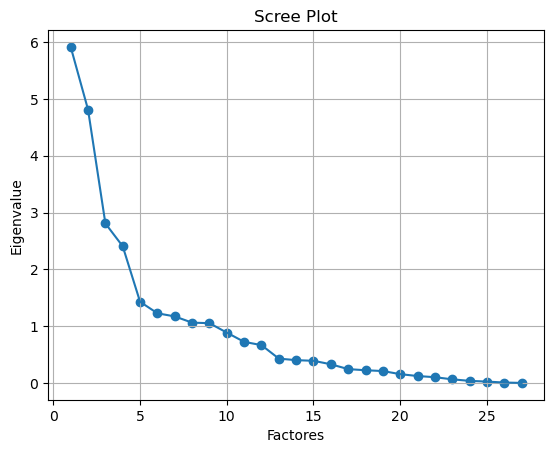

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.087068  0.899691  0.097973 -0.158548  0.197652 -0.067786   
VIVTOT2010       0.137825  0.943256  0.120846 -0.042074  0.094459 -0.082923   
VIVPARDES2010   -0.021995  0.122881 -0.017114  0.085143  0.351230 -0.018137   
VIVPARDES2020    0.047192  0.879997  0.112411  0.327535  0.198184  0.049777   
VIV1DO2010       0.020599  0.675276  0.486419 -0.124579  0.288845 -0.041978   
VIV1DO2020      -0.001596  0.635837  0.532773  0.247533  0.261578  0.044540   
VIV1C2010       -0.161984  0.103133  0.315660 -0.060883  0.645905  0.020955   
VIV1C2020       -0.128049  0.158755  0.291959  0.103792  0.623230  0.032175   
VIV2C2010       -0.026860  0.323009  0.647511 -0.039816  0.264868 -0.045491   
VIV2C2020       -0.004120  0.292533  0.754040  0.218960  0.173737  0.036257   
area_ha         -0.355081  0.347887  0.055480  0.249203  0.563819 -0.005827   
FILTRADO         0.770319 -0.223714 -0.061882  0.025218  0.001629 -0.018803   
DESHABITACION   -0.080081 -0.024966 -0.013286  0.003611 -0.001549  0.006793   
PROM_DESHAB_MUN -0.191870 -0.048656  0.114688  0.095865  0.155854  0.002265   
TASA_POP_MUN     0.019193  0.026027  0.039004  0.151611  0.034308  0.030519   
DIFPOP          -0.035663 -0.028335  0.077988  0.842903  0.059599  0.188884   
DIFVIV          -0.141863  0.036199  0.044016  0.796366  0.237229  0.260578   
RELPOP          -0.011366 -0.028180 -0.005566  0.147143 -0.011150  0.964641   
RELVIV          -0.093034 -0.068619  0.000307  0.288430  0.017872  0.713651   
DENS_POP20       0.945262  0.109945  0.021908  0.074435 -0.127556  0.011792   
DENS_POP10       0.868640  0.149723 -0.067867 -0.216743 -0.073864 -0.082303   
DENS_VIV20       0.960163  0.104772  0.052097  0.079835 -0.152102  0.013633   
DENS_VIV10       0.923127  0.149583  0.021647 -0.115277 -0.141062 -0.077096   
CPERC2010        0.021286  0.018659 -0.396082 -0.058291 -0.050161  0.359867   
CPERC2020        0.024801  0.049480 -0.416514 -0.090398 -0.028574 -0.003017   
HABXVIV2010     -0.087187 -0.011443 -0.011173 -0.136223  0.084737 -0.032406   
HABXVIV2020      0.061772  0.051540 -0.004043  0.046721  0.037073 -0.010630   

                       A7        A8        A9  
POPTOT2010       0.078814  0.236739 -0.114952  
VIVTOT2010      -0.011061 -0.152229 -0.077663  
VIVPARDES2010   -0.017698 -0.002773  0.012476  
VIVPARDES2020   -0.076203 -0.024548  0.255564  
VIV1DO2010       0.045152 -0.032473 -0.036909  
VIV1DO2020      -0.038514 -0.051271 -0.082667  
VIV1C2010        0.142686  0.029376  0.011045  
VIV1C2020        0.029432  0.080835 -0.040848  
VIV2C2010        0.174763  0.034327 -0.004644  
VIV2C2020        0.146487 -0.077233 -0.018008  
area_ha          0.017774  0.030343 -0.005928  
FILTRADO        -0.028274 -0.032325  0.049339  
DESHABITACION   -0.061202 -0.029489  0.768405  
PROM_DESHAB_MUN  0.156996  0.006467  0.037148  
TASA_POP_MUN     0.109501 -0.040905  0.025801  
DIFPOP           0.131210 -0.296163 -0.064609  
DIFVIV          -0.092442  0.239110  0.017890  
RELPOP           0.080813 -0.190513  0.015233  
RELVIV          -0.053989  0.155973  0.007132  
DENS_POP20       0.179576 -0.006141 -0.103553  
DENS_POP10       0.064724  0.278531 -0.065083  
DENS_VIV20      -0.085883 -0.107142 -0.007715  
DENS_VIV10      -0.044575 -0.190559 -0.035859  
CPERC2010       -0.338284 -0.328703 -0.057105  
CPERC2020       -0.657837 -0.086986 -0.068488  
HABXVIV2010      0.287895  0.883898 -0.053220  
HABXVIV2020      0.864319  0.249329 -0.204530

A1        A2        A3        A4        A5        A6  \
SS Loadings     4.300956  3.830506  2.098896  1.931181  1.748715  1.711378   
Proportion Var  0.159295  0.141871  0.077737  0.071525  0.064767  0.063384   
Cumulative Var  0.159295  0.301165  0.378902  0.450427  0.515195  0.578579   

                      A7        A8        A9  
SS Loadings     1.588824  1.392573  0.763706  
Proportion Var  0.058845  0.051577  0.028285  
Cumulative Var  0.637424  0.689001  0.717286

In [64]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_f_fil

#hacer CVEGEO index y borrar columnas

# MAPA_df_f = MAPA_df_f.drop(columns=['CVE_ENT', 'CVE_MUN', 'NOM_MUN'])

# MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=9, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7','A8','A9']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7','A8','A9']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

### Rango d

In [120]:
sheet_name = 'Deshab D'

Chi square: 196550.67936714337 p_value: 0.0
Modelo KMO: 0.685880636151951
Valores propios
[ 1.15159460e+01  4.37491712e+00  3.66745529e+00  2.33732494e+00
  1.97429911e+00  1.58007880e+00  1.15866675e+00  1.09866928e+00
  1.01372448e+00  8.59252984e-01  6.65538571e-01  5.95466316e-01
  5.45845904e-01  4.95701843e-01  4.04034719e-01  3.69444374e-01
  3.01999818e-01  2.29953491e-01  1.85322059e-01  1.67000620e-01
  1.32053389e-01  7.82373705e-02  7.16253788e-02  5.91486057e-02
  4.62625244e-02  2.89113879e-02  1.97338295e-02  1.43212651e-02
  5.41137241e-03  3.65237898e-03  1.34999912e-15  5.38376636e-16
  2.64749505e-16 -1.57287911e-15]


C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


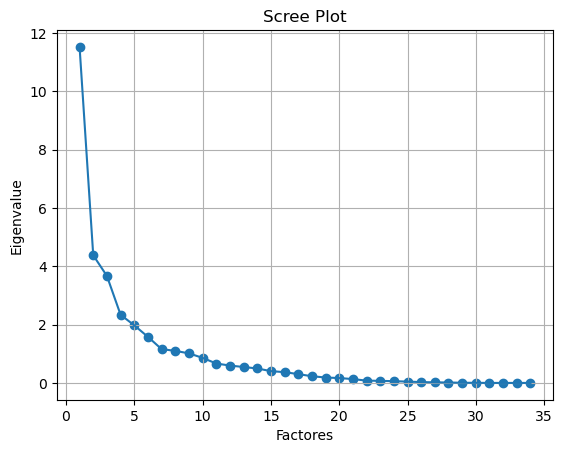

A1        A2        A3        A4        A5        A6  \
POPTOT2010       0.871079  0.044830  0.272884 -0.187205  0.159841 -0.152959   
POPTOT2020       0.813901  0.062504  0.338974  0.265701  0.165944  0.060186   
VIVTOT2010       0.890214  0.074476  0.235672 -0.227310 -0.092962 -0.064832   
VIVTOT2020       0.907421  0.025284  0.279068  0.217973 -0.080294  0.047441   
VIVPARDES2020    0.812142 -0.017997  0.272055  0.165105 -0.079621  0.050536   
VIV1DO2010       0.656393  0.050263  0.596756 -0.251673 -0.050010 -0.044231   
VIV1DO2020       0.609637  0.061050  0.605720  0.269057 -0.052166  0.028327   
VIV2YMDO2010     0.918146  0.046073 -0.061218 -0.164238 -0.018056 -0.127950   
VIV2YMDO2020     0.911678  0.072520  0.021651  0.191240 -0.026953  0.044162   
VIV1C2010        0.027062 -0.058821  0.519918 -0.061933  0.025821  0.023070   
VIV1C2020        0.038203 -0.054127  0.474784  0.337250  0.037479  0.010137   
VIV2C2010        0.179174  0.072355  0.624648  0.014855 -0.007477 -0.043540   
VIV2C2020        0.157416  0.062425  0.670171  0.337019 -0.023105  0.028302   
VIV3CYM2010      0.949835  0.055003 -0.070306 -0.223708 -0.031959 -0.103073   
VIV3CYM2020      0.966886  0.080972 -0.043794  0.096582 -0.038892  0.038650   
area_ha          0.265875 -0.370688  0.241962  0.156369  0.005847 -0.006575   
FILTRADO        -0.142608  0.758472  0.000388  0.044464  0.017390 -0.034204   
DESHABITACION   -0.367258 -0.102640  0.021142 -0.019155  0.184957 -0.075682   
PROM_DESHAB_MUN -0.107168 -0.162579  0.107881  0.105176 -0.010474  0.089180   
TASA_POP_MUN    -0.042455 -0.000142  0.066311  0.102316 -0.010391  0.054145   
DIFPOP          -0.245672  0.016792  0.071786  0.709697 -0.016122  0.373442   
DIFVIV           0.221842 -0.084610  0.150778  0.821009  0.007232  0.232709   
RELPOP          -0.053742 -0.007172  0.027400  0.162262 -0.016932  0.993418   
RELVIV          -0.001427 -0.056611 -0.012336  0.281760  0.005127  0.634305   
DENS_POP20       0.079758  0.962164  0.045103  0.072708  0.071801  0.056810   
DENS_POP10       0.099788  0.923034  0.022320 -0.076208  0.081359 -0.133388   
DENS_VIV20       0.255193  0.914716  0.022692  0.065094 -0.084517  0.087407   
DENS_VIV10       0.213409  0.914377  0.038354 -0.119034 -0.085574 -0.046203   
CUARTOS2010      0.947355  0.045573  0.033699 -0.246698 -0.027468 -0.092491   
CUARTOS2020      0.961929  0.072730  0.043935  0.158959 -0.031906  0.032559   
CPERC2010       -0.107917 -0.072390 -0.101052 -0.064927 -0.102920  0.349091   
CPERC2020       -0.126240 -0.068384 -0.107140 -0.015749 -0.096246 -0.140611   
HABXVIV2010     -0.049665 -0.001050  0.002579  0.007091  0.992915 -0.044451   
HABXVIV2020     -0.058328  0.020791  0.013097 -0.010087  0.946481  0.020142   

                       A7  
POPTOT2010       0.150894  
POPTOT2020       0.244351  
VIVTOT2010       0.091008  
VIVTOT2020       0.111131  
VIVPARDES2020    0.042445  
VIV1DO2010       0.077573  
VIV1DO2020       0.102928  
VIV2YMDO2010     0.009603  
VIV2YMDO2020     0.106983  
VIV1C2010       -0.000969  
VIV1C2020       -0.051746  
VIV2C2010        0.180449  
VIV2C2020        0.178323  
VIV3CYM2010     -0.036662  
VIV3CYM2020      0.060684  
area_ha          0.084705  
FILTRADO        -0.063581  
DESHABITACION   -0.560079  
PROM_DESHAB_MUN  0.163148  
TASA_POP_MUN     0.115588  
DIFPOP           0.121641  
DIFVIV           0.071676  
RELPOP           0.037758  
RELVIV           0.044529  
DENS_POP20       0.121440  
DENS_POP10       0.040780  
DENS_VIV20       0.126826  
DENS_VIV10       0.094760  
CUARTOS2010     -0.042495  
CUARTOS2020      0.039701  
CPERC2010       -0.632754  
CPERC2020       -0.688844  
HABXVIV2010      0.025224  
HABXVIV2020      0.025025

A1        A2        A3        A4        A5        A6  \
SS Loadings     10.404347  4.279776  2.599216  2.174125  2.050950  1.857645   
Proportion Var   0.306010  0.125876  0.076448  0.063945  0.060322  0.054637   
Cumulative Var   0.306010  0.431886  0.508334  0.572278  0.632600  0.687237   

                      A7  
SS Loadings     1.514355  
Proportion Var  0.044540  
Cumulative Var  0.731777

In [121]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_d

#hacer CVEGEO index y borrar columnas

MAPA_df_f = MAPA_df_f.drop(columns=[ 'CVEPOP', 'CVEVIV', 'TIPOLOGIA', 'R_DESHAB', 'VIVPARDES2010',
       'SUBTIPOLOGÍA'])

MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

# Escalar los datos
scaler = StandardScaler()
MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

# Pruebas de esfericidad de Bartlett y KMO
chi_square_value, p_value = calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square:', chi_square_value, 'p_value:', p_value)

kmo_all, kmo_model = calculate_kmo(MAPA_df_f)
print('Modelo KMO:', kmo_model)

# Análisis factorial
fa = FactorAnalyzer(n_factors=41, rotation=None)
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Crear scree plot
plt.scatter(range(1, MAPA_df_f.shape[1] + 1), ev)
plt.plot(range(1, MAPA_df_f.shape[1] + 1), ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Análisis factorial con rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
fa.fit(MAPA_df_f)
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3', 'A4', 'A5', 'A6', 'A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Obtener la varianza de cada factor
fa.get_factor_variance()
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_names, index=['SS Loadings', 'Proportion Var', 'Cumulative Var'])
display(varianza_df)

In [122]:
# Verificar si el archivo existe y cargarlo
if os.path.exists(excel_file):
    with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
        book = writer.book
        if sheet_name in book.sheetnames:
            print(f"La hoja {sheet_name} ya existe en el archivo {excel_file}.")
        else:
            loadings_df.to_excel(writer, sheet_name=sheet_name, startrow=0, index=True)
            
            # Agregar título a la tabla de loadings
            worksheet = writer.sheets[sheet_name]
            worksheet.cell(row=1, column=1, value='Loadings')
        print(f"Los loadings han sido guardados exitosamente en la nueva pestaña {sheet_name} del archivo Excel.")
else:
    print(f"El archivo {excel_file} no existe. Por favor, crea el archivo primero.")


Los loadings han sido guardados exitosamente en la nueva pestaña Deshab D del archivo Excel.


#### filtro

In [81]:
# Check for highly correlated variables
correlation_matrix = MAPA_df_f.corr()
highly_correlated = (correlation_matrix > 0.95) & (correlation_matrix < 1.0)

print("Highly Correlated Variables:\n", highly_correlated)

# Drop one of each pair of highly correlated variables
variables_to_drop = set()
for var in highly_correlated.columns:
    variables_to_drop.update(set(highly_correlated.index[highly_correlated[var]]))
MAPA_df_f_fil = MAPA_df_f.drop(columns=variables_to_drop)


Highly Correlated Variables:
                  POPTOT2010  POPTOT2020  VIVTOT2010  VIVTOT2020  \
POPTOT2010            False       False       False       False   
POPTOT2020            False       False       False       False   
VIVTOT2010            False       False       False       False   
VIVTOT2020            False       False       False       False   
VIVPARDES2020         False       False       False       False   
VIV1DO2010            False       False       False       False   
VIV1DO2020            False       False       False       False   
VIV2YMDO2010          False       False       False       False   
VIV2YMDO2020          False       False       False       False   
VIV1C2010             False       False       False       False   
VIV1C2020             False       False       False       False   
VIV2C2010             False       False       False       False   
VIV2C2020             False       False       False       False   
VIV3CYM2010           False     

In [53]:
#asignar DF a tratar
MAPA_df_f= MAPA_df_f_fil

#hacer CVEGEO index y borrar columnas

# MAPA_df_f = MAPA_df_f.drop(columns=['CVE_ENT', 'CVE_MUN', 'NOM_MUN'])

# MAPA_df_f = MAPA_df_f.set_index('CVEGEO', drop=True)

#borrar nulos
MAPA_df_f.dropna(inplace=True)

#quitar valores infinitos
MAPA_df_f = MAPA_df_f.replace([np.inf, -np.inf], np.nan).dropna()

#escalar
scaler = StandardScaler()

MAPA_df_f = pd.DataFrame(scaler.fit_transform(MAPA_df_f), columns=MAPA_df_f.columns, index=MAPA_df_f.index)

#barlett test

chi_square_value,p_value=calculate_bartlett_sphericity(MAPA_df_f)
print('Chi square')
print(chi_square_value, p_value)
print()


kmo_all,kmo_model=calculate_kmo(MAPA_df_f)
print('Modelo KMO')
print(kmo_model)
print()

# Crear un objeto FactorAnalyzer con el número de factores deseados
fa = FactorAnalyzer(n_factors=41, rotation=None)

# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)

# Obtener los valores propios (eigenvalues)
ev, v = fa.get_eigenvalues()

# Imprimir los valores propios
print("Valores propios")
print(ev)

# Create scree plot using matplotlib
plt.scatter(range(1,MAPA_df_f.shape[1]+1),ev)
plt.plot(range(1,MAPA_df_f.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factores')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

# Crear un objeto FactorAnalyzer con el número de factores deseados y rotación Varimax
fa = FactorAnalyzer(n_factors=7, rotation="varimax")
# Ajustar el modelo de análisis factorial a los datos
fa.fit(MAPA_df_f)
# Obtener los loadings o cargas factoriales
loadings = fa.loadings_

# Imprimir los loadings
column_names = ['A1', 'A2', 'A3','A4','A5','A6','A7']
loadings_df = pd.DataFrame(loadings, columns=column_names, index=MAPA_df_f.columns)
display(loadings_df)

# Get variance of each factors
fa.get_factor_variance()

column_name = ['A1', 'A2', 'A3','A4','A5','A6','A7']
varianza_df = pd.DataFrame(fa.get_factor_variance(), columns=column_name, index=(['SS Loadings', 'Proportion Var', 'Cumulative Var']))
display(varianza_df)

Chi square
nan nan

Modelo KMO
nan



C:\Users\Alejandro\anaconda3\Lib\site-packages\numpy\linalg\linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
C:\Users\Alejandro\anaconda3\Lib\site-packages\factor_analyzer\utils.py:90: RuntimeWarning: invalid value encountered in divide
  x = (x - np.mean(x, axis=0)) / np.std(x, axis=0, ddof=0)


ValueError: array must not contain infs or NaNs

#### revisión de datos

In [74]:
print(MAPA_df_f.describe())

         POPTOT2010    POPTOT2020    VIVTOT2010    VIVTOT2020  VIVPARDES2010  \
count  1.106000e+03  1.106000e+03  1.106000e+03  1.106000e+03         1106.0   
mean   9.636656e-18  2.569775e-17  3.854662e-17 -1.284887e-17            0.0   
std    1.000452e+00  1.000452e+00  1.000452e+00  1.000452e+00            0.0   
min   -9.746384e-01 -9.974182e-01 -9.383291e-01 -9.854406e-01            0.0   
25%   -7.438281e-01 -7.781415e-01 -7.862160e-01 -8.495177e-01            0.0   
50%   -3.151804e-01 -2.664959e-01 -2.538199e-01 -1.699035e-01            0.0   
75%    3.772505e-01  4.278804e-01  4.306893e-01  4.417492e-01            0.0   
max    4.960484e+00  6.677266e+00  6.667329e+00  7.305852e+00            0.0   

       VIVPARDES2020   VIV1DO2010    VIV1DO2020  VIV2YMDO2010  VIV2YMDO2020  \
count   1.106000e+03  1106.000000  1.106000e+03  1.106000e+03  1.106000e+03   
mean    3.212219e-18     0.000000 -2.569775e-17 -1.284887e-17  2.890997e-17   
std     1.000452e+00     1.000452  1.00045

In [75]:
for column in MAPA_df_f.columns:
    nans = MAPA_df_f[column].isna().sum()
    infs = np.isinf(MAPA_df_f[column]).sum()
    if nans > 0 or infs > 0:
        print(f"Columna {column} tiene {nans} NaNs y {infs} valores infinitos")


C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


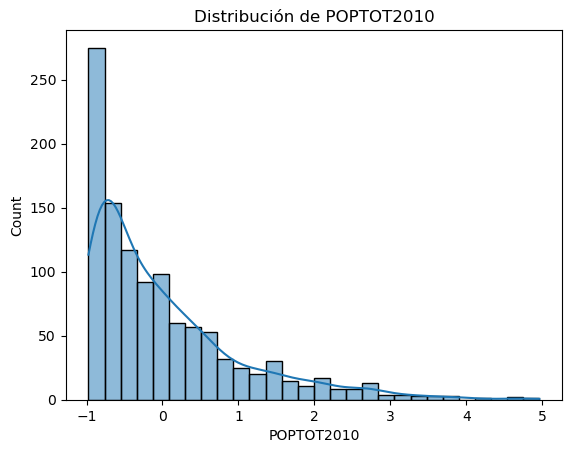

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


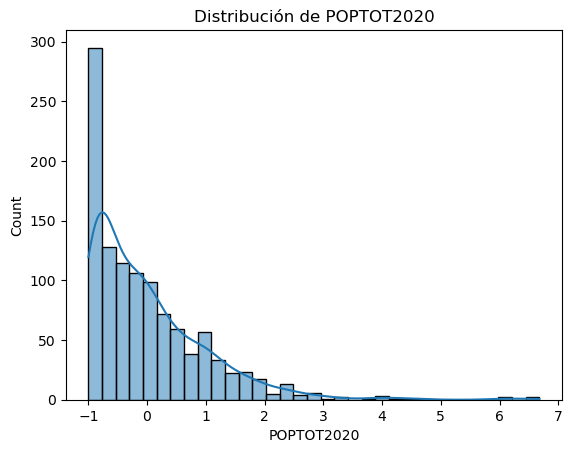

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


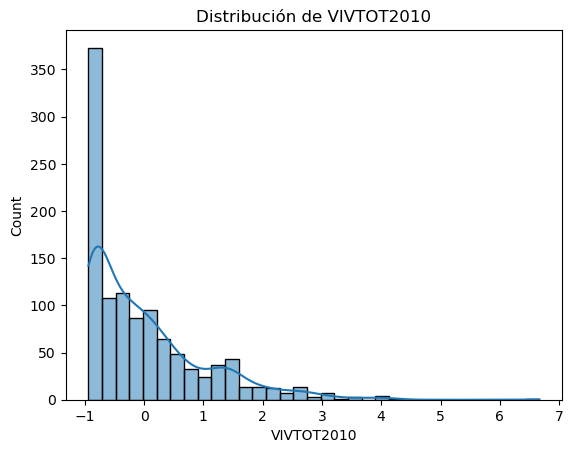

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


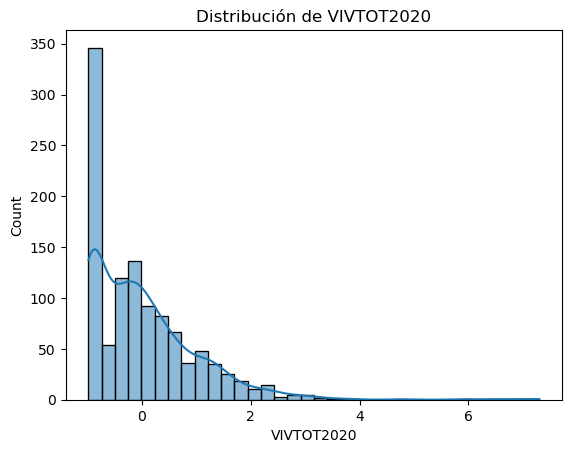

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


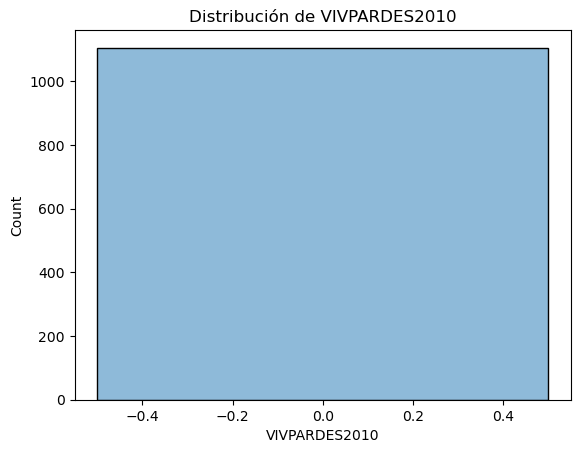

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


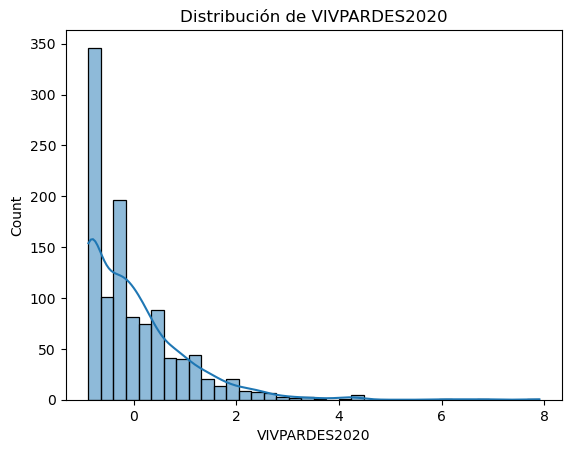

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


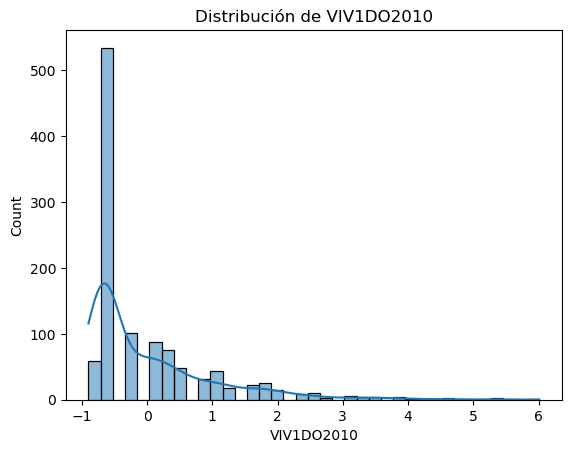

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


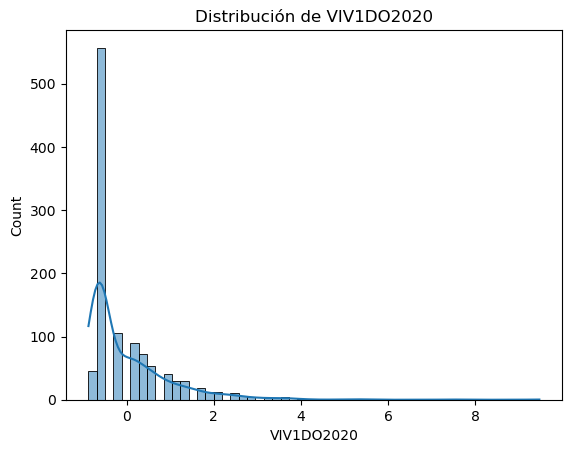

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


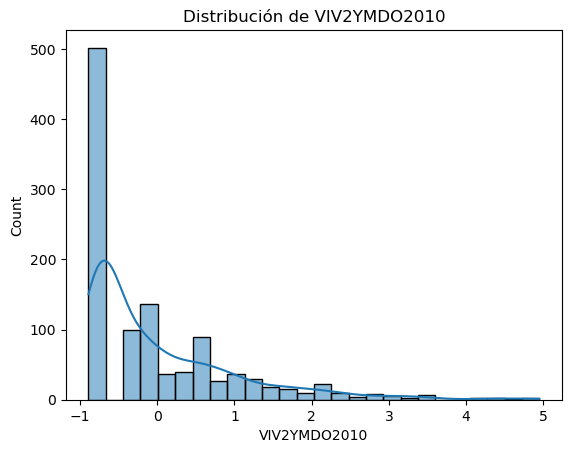

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


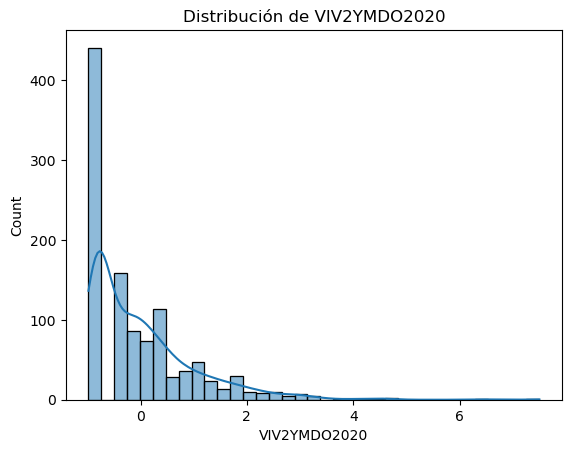

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


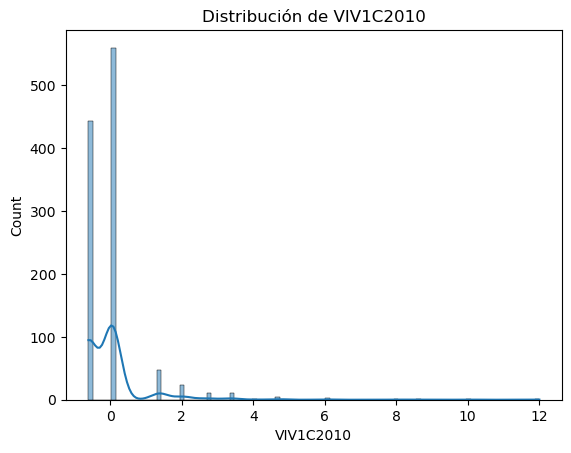

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


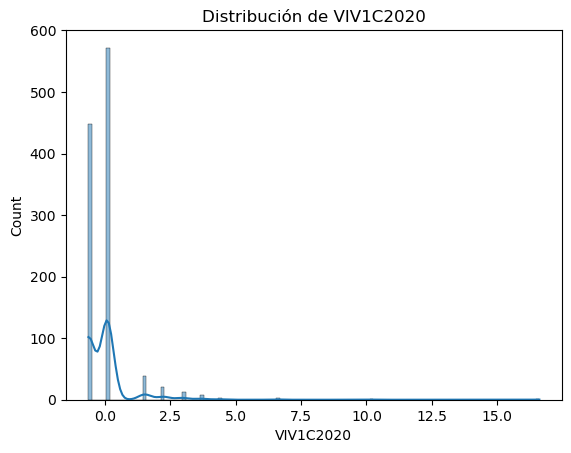

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


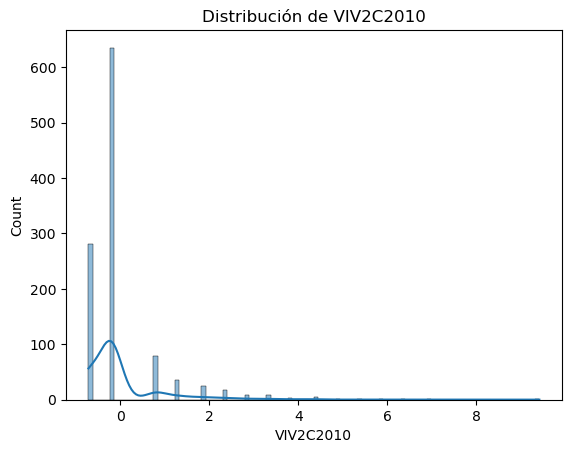

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


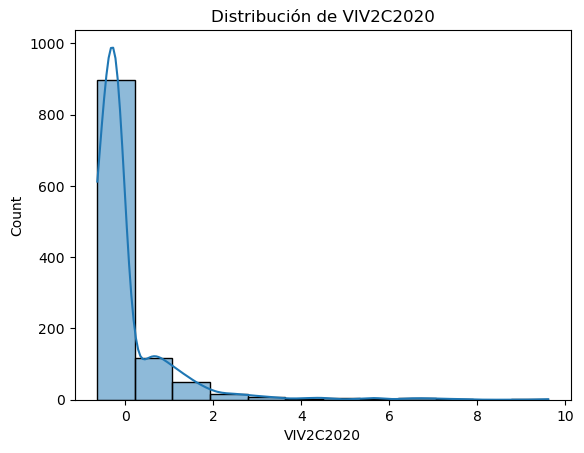

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


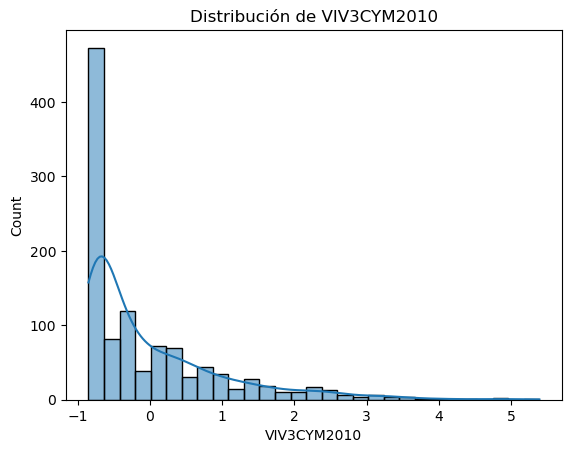

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


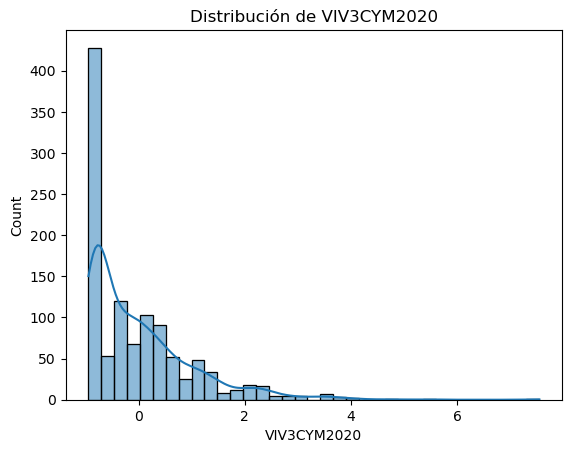

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


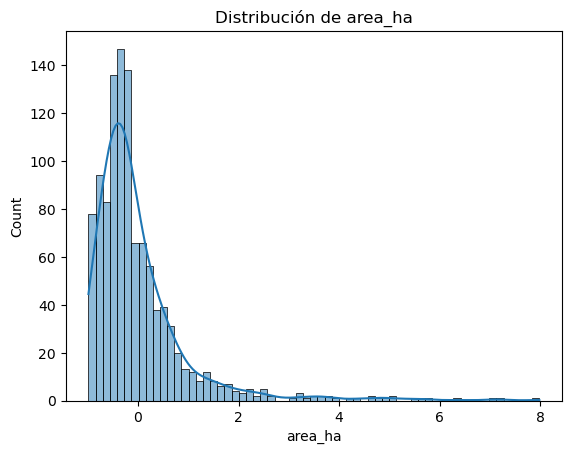

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


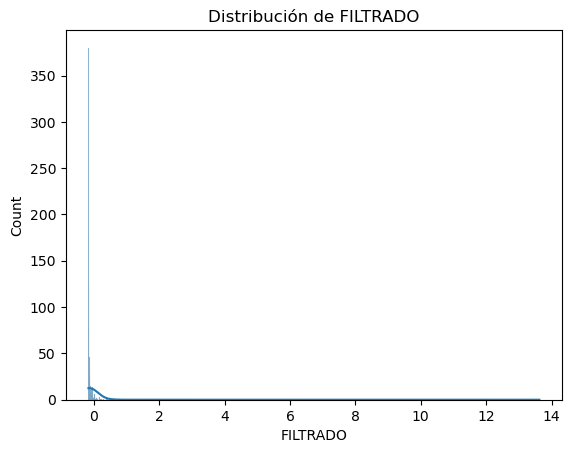

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


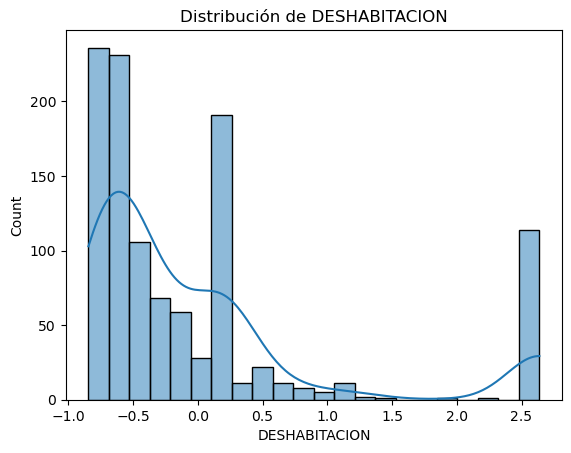

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


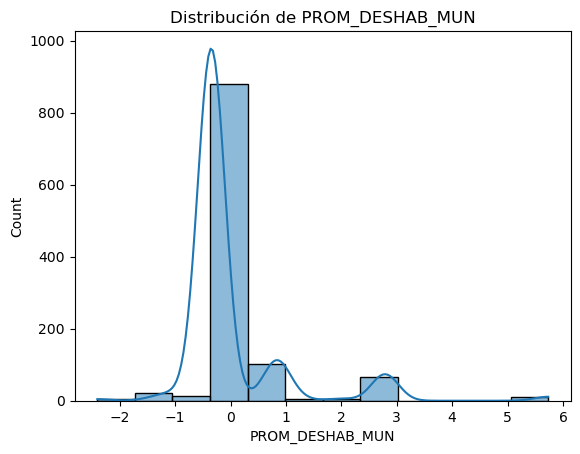

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


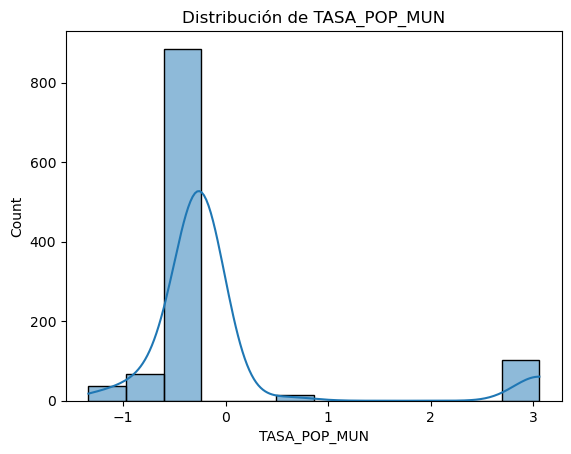

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


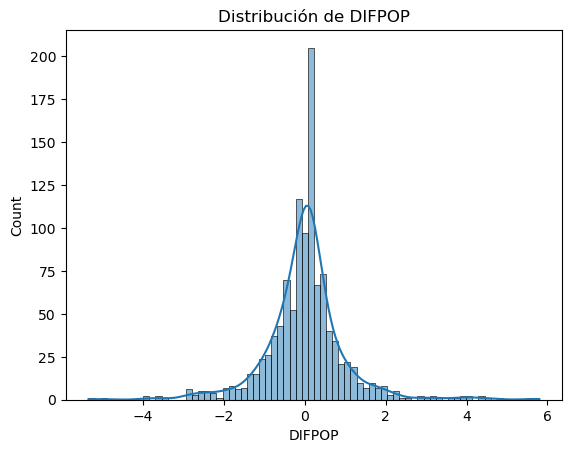

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


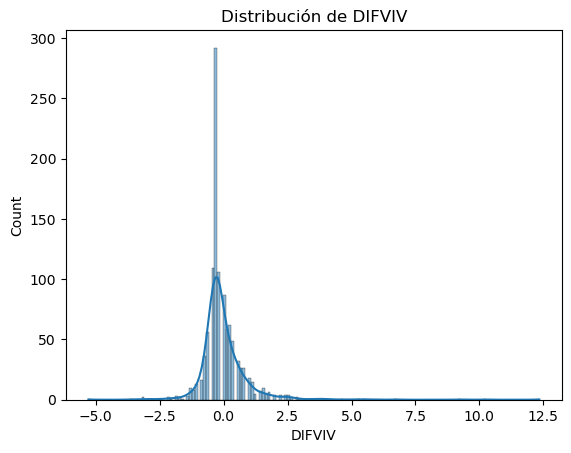

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


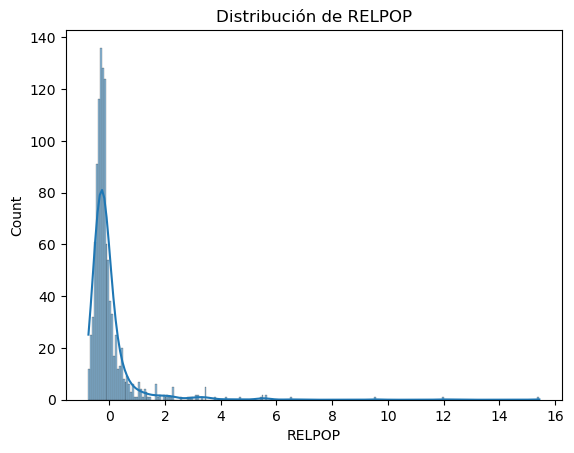

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


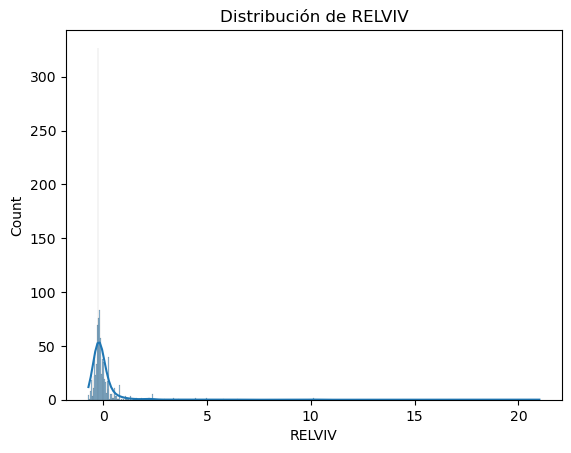

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


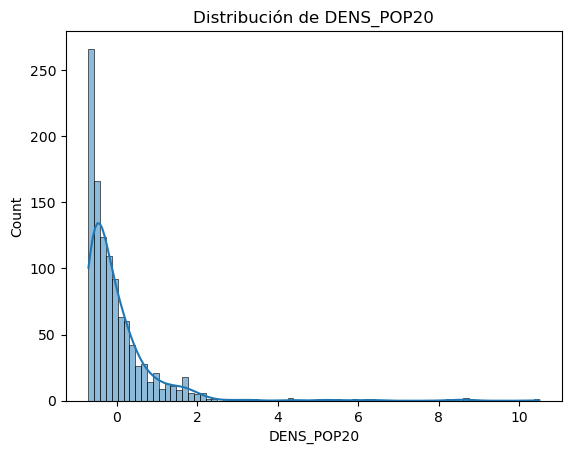

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


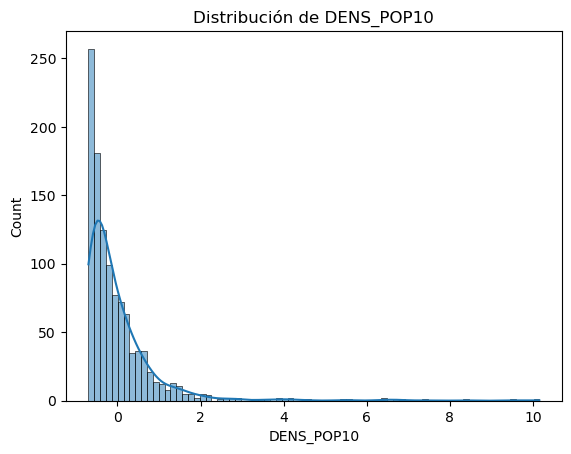

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


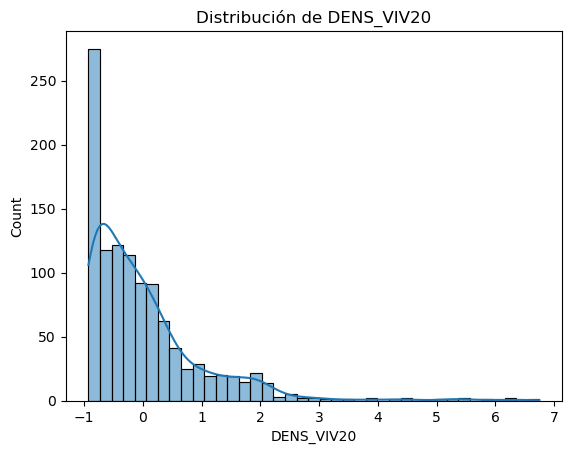

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


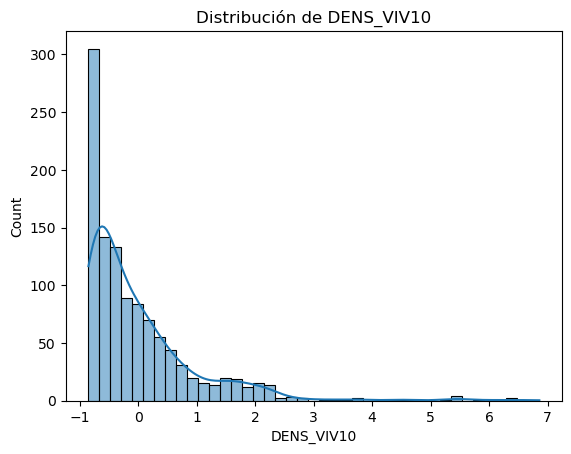

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


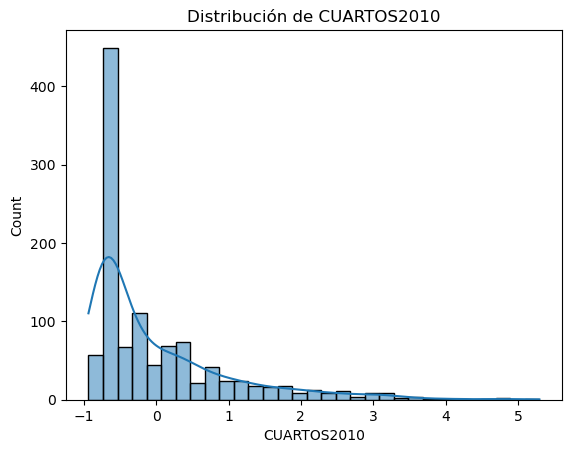

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


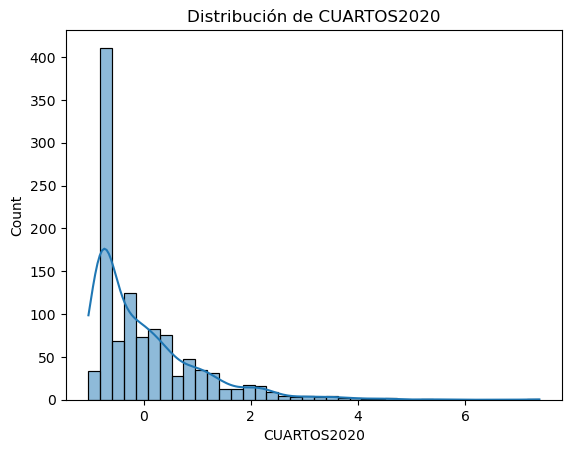

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


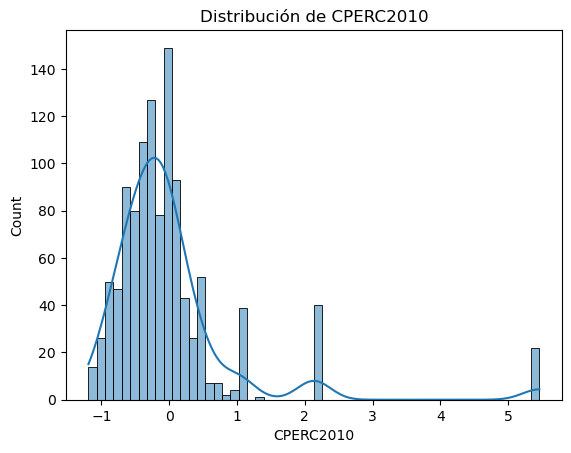

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


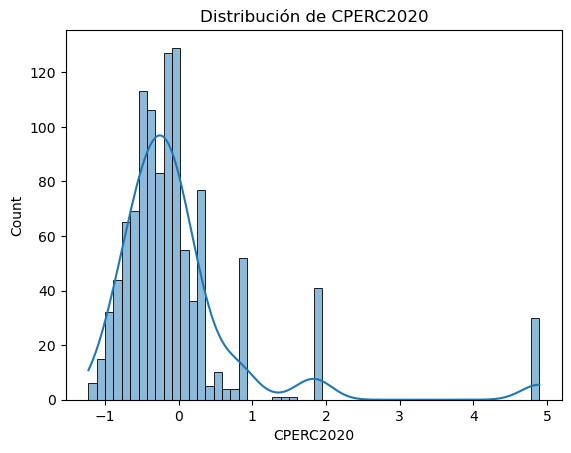

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


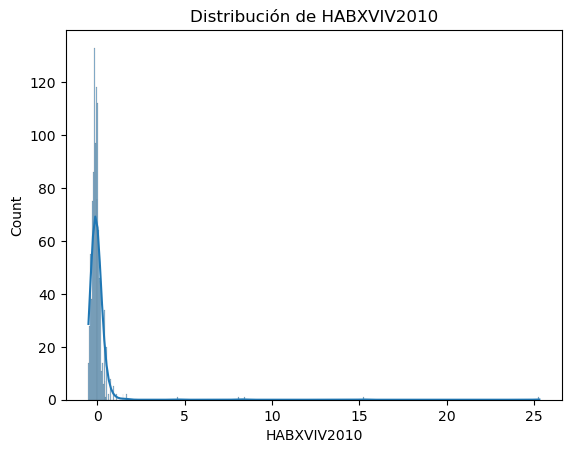

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


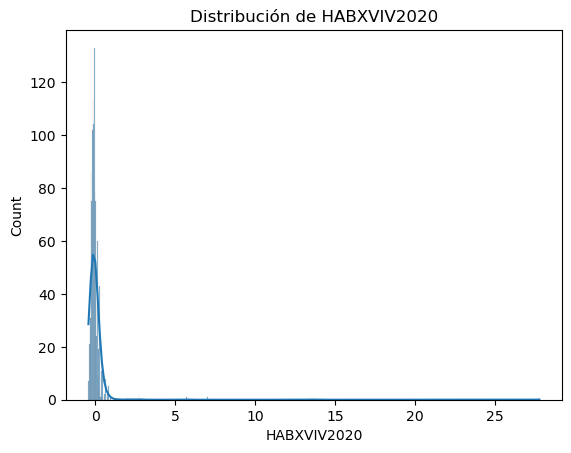

C:\Users\Alejandro\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


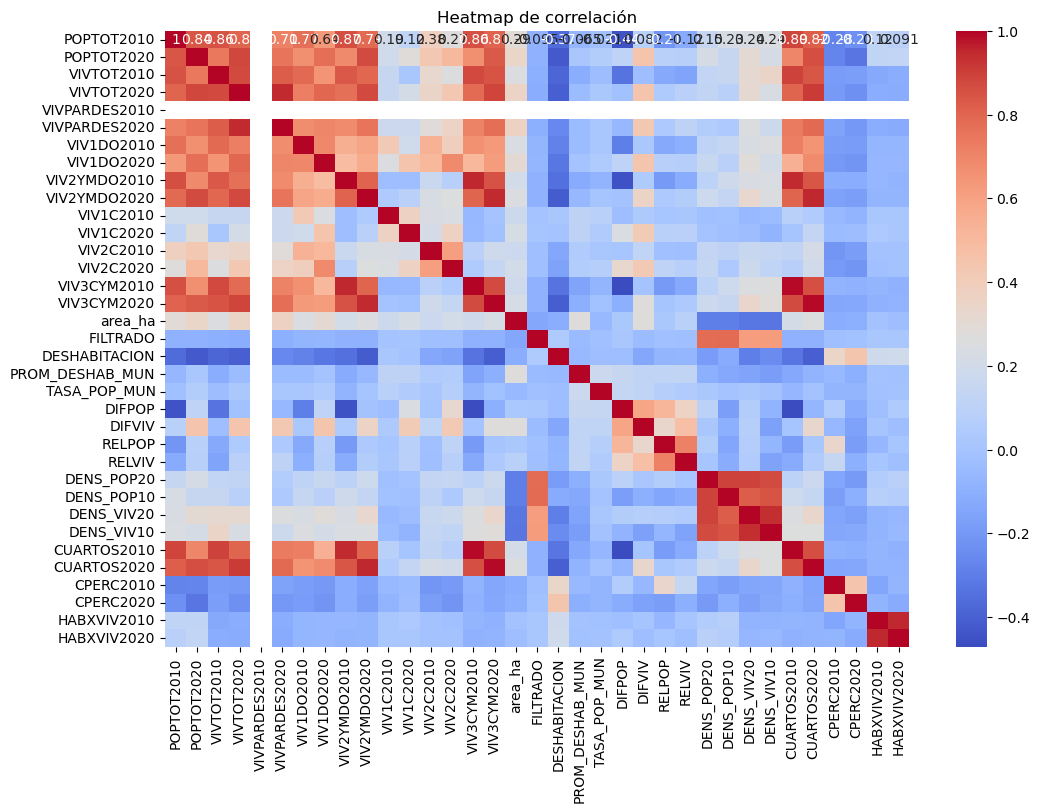

In [76]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograma para cada columna
for column in MAPA_df_f.columns:
    plt.figure()
    sns.histplot(MAPA_df_f[column], kde=True)
    plt.title(f'Distribución de {column}')
    plt.show()

# Heatmap para visualizar correlaciones
plt.figure(figsize=(12, 8))
sns.heatmap(MAPA_df_f.corr(), annot=True, cmap='coolwarm')
plt.title('Heatmap de correlación')
plt.show()
